<a href="https://colab.research.google.com/github/GabriellJacinto/Electrical-Behaviour-Prediction/blob/main/CMOS/NAND2/Models/simu_1/NAND2_Advanced_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap

Anteriormente treinamos quatro algoritmos para três variáveis alvo diferentes. Tivemos bons resultados para alguns, piores para outros, mas no geral conseguimos averiguar que Machine Learning pode servir para prever resultados de simulações elétricas. Dessa vez queremos treinar algoritmos mais avançados que nos retornem multi outputs, com uma variação maior de valores nas variáveis explicativas. Os valores a serem permutados nos dados da simulação Monte Carlo (spectre) de um circuito NAND 2 serão:
* NFET Phig*
* PFET Phig*
* Temperature (-25, 25, 0, 50, 75, 100°C)
* Voltage (0.6, 0.7, 0.8, 0.9V)
* Capacitance (1f, 4f, 8f, 16f)
* Fins (1, 2, 3, 4, 5)
* Hfin (3.2e-8)
* Length (2.1e-8)

Os nossos algoritmos precisam prever em um output (preferencialmente) as variáveis de energia, atraso de subida e atraso de descida (```iint```, ```tplh``` e ```tphl```respectivamente). **Não irei trabalhar com regressores lineares dessa vez**. Alguns algoritmos que tenho em mente:
   

- [ ] Uma ou duas arquiteturas de Rede Neural
- [ ] SVR com um kernel polinomial ou similar
- [ ] RandomForest
- [ ] MultiOutputEstimator para os últimos dois



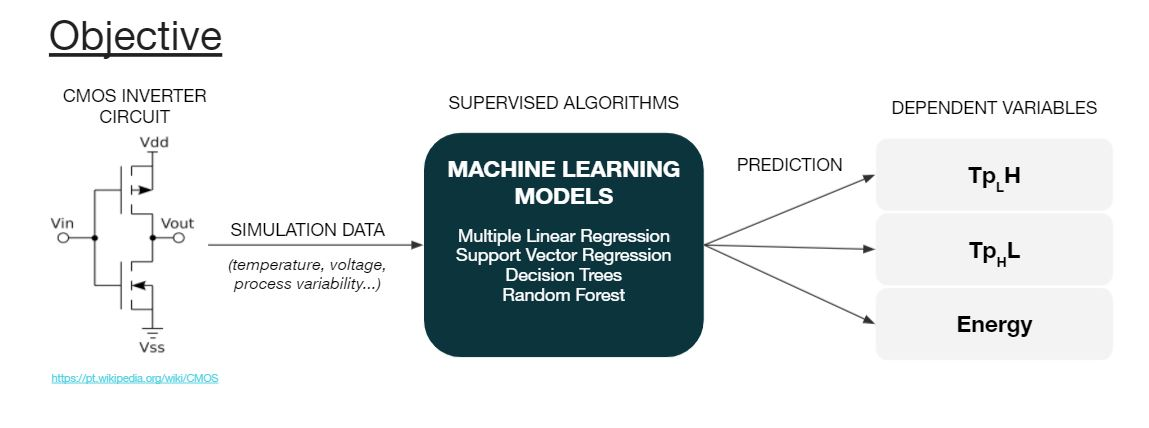

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import logging

In [2]:
!pwd

/Users/gabriellimajacinto/Documents/Electrical-Behaviour-Prediction/FINFET/5nm/NAND/Model


In [3]:
results_dir = "../../../Model/results/"

logger = logging.getLogger()
fhandler = logging.FileHandler(filename='results_log.txt', mode='a')
logger.setLevel(logging.INFO)#send two messages to the logger
logger.addHandler(fhandler)

In [4]:
path = "../Data/sim1"
os.chdir(path)
print("Current path:", os.getcwd())
print("Files:")
for file in os.listdir():
  print(" ", file)

Current path: /Users/gabriellimajacinto/Documents/Electrical-Behaviour-Prediction/FINFET/5nm/NAND/Data/sim1
Files:
  simResults_NAND5fet
  treated_data_inverter.csv
  params.json
  var.sp
  nand.sp
  all_results.csv


# Ajustando o .csv

In [5]:
data = pd.read_csv('all_results.csv', index_col=0)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8400 entries, 0 to 8399
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   nmos_rvt:@:nfet_phig:@:IGNC  8400 non-null   float64
 1   pmos_rvt:@:pfet_phig:@:IGNC  8400 non-null   float64
 2   load                         8400 non-null   object 
 3   Vin                          8400 non-null   float64
 4   number_fin                   8400 non-null   int64  
 5   tplha                        8400 non-null   float64
 6   tphla                        8400 non-null   float64
 7   tplhb                        8400 non-null   float64
 8   tphlb                        8400 non-null   float64
 9   iint                         8400 non-null   float64
 10  temper                       8400 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 787.5+ KB


In [7]:
#data = data.apply(pd.to_numeric, errors='coerce')
data.isna().sum()

nmos_rvt:@:nfet_phig:@:IGNC    0
pmos_rvt:@:pfet_phig:@:IGNC    0
load                           0
Vin                            0
number_fin                     0
tplha                          0
tphla                          0
tplhb                          0
tphlb                          0
iint                           0
temper                         0
dtype: int64

In [8]:
data = data.dropna()
data.isna().sum()

nmos_rvt:@:nfet_phig:@:IGNC    0
pmos_rvt:@:pfet_phig:@:IGNC    0
load                           0
Vin                            0
number_fin                     0
tplha                          0
tphla                          0
tplhb                          0
tphlb                          0
iint                           0
temper                         0
dtype: int64

In [9]:
data = data.rename(columns={'nmos_rvt:@:nfet_phig:@:IGNC': 'nfetPhig', 
                            'pmos_rvt:@:pfet_phig:@:IGNC': 'pfetPhig',
                            'Vin': 'voltage', 
                            'load': 'capacitance',
                            'temper': 'temperature',
                            'number_fin': 'finsNumber',
                            'iint': 'energy',
                            'tphla': 'tphLa',
                            'tplha': 'tplHa',
                            'tphlb': 'tphLb',
                            'tplhb': 'tplHb',
                            })

# data = data.drop("temper", axis=1)
# data = data.drop("alter", axis=1)
# data = data.drop("index", axis=1)

data["finLength"] = 2.1e-8
data["finHeight"] = 3.2e-8

In [10]:
data["capacitance"] = data["capacitance"].map(lambda x: (float(x[:-1]))*10**(-15))

In [11]:
data.capacitance.unique()

array([1.e-15, 2.e-15, 3.e-15, 4.e-15])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8400 entries, 0 to 8399
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   nfetPhig     8400 non-null   float64
 1   pfetPhig     8400 non-null   float64
 2   capacitance  8400 non-null   float64
 3   voltage      8400 non-null   float64
 4   finsNumber   8400 non-null   int64  
 5   tplHa        8400 non-null   float64
 6   tphLa        8400 non-null   float64
 7   tplHb        8400 non-null   float64
 8   tphLb        8400 non-null   float64
 9   energy       8400 non-null   float64
 10  temperature  8400 non-null   float64
 11  finLength    8400 non-null   float64
 12  finHeight    8400 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 918.8 KB


In [13]:
data.to_csv('treated_data_inverter.csv') 

# Limpando e Explorando os Dados

In [14]:
data = pd.read_csv("treated_data_inverter.csv", index_col=0)
data.head()

nfetPhig  pfetPhig   capacitance  voltage  finsNumber         tplHa  \
0    0.0000    0.0000  1.000000e-15      0.6           1  2.576682e-11   
1   -0.8014   -0.8294  1.000000e-15      0.6           1  3.065364e-11   
2   -0.2677    0.2150  1.000000e-15      0.6           1  2.500872e-11   
3    1.6757    0.8946  1.000000e-15      0.6           1  2.200222e-11   
4    0.2014    1.0447  1.000000e-15      0.6           1  2.147370e-11   

          tphLa         tplHb         tphLb        energy  temperature  \
0  3.750116e-11  2.622419e-11  3.769792e-11 -1.234081e-15         75.0   
1  3.182279e-11  3.158739e-11  3.112569e-11 -1.233083e-15         75.0   
2  3.512074e-11  2.544561e-11  3.525710e-11 -1.222437e-15         75.0   
3  6.316486e-11  2.242358e-11  6.733145e-11 -1.233281e-15         75.0   
4  3.965510e-11  2.204355e-11  4.148134e-11 -1.228836e-15         75.0   

      finLength     finHeight  
0  2.100000e-08  3.200000e-08  
1  2.100000e-08  3.200000e-08  
2  2.100000e-08  3.200000e-08  
3  2.100000e-08  3.200000e-08  
4  2.100000e-08  3.200000e-08

In [15]:
data[["energy", "tphLa", "tplHa", "tphLb", "tplHb"]].describe()

energy         tphLa         tplHa         tphLb         tplHb
count  8.400000e+03  8.400000e+03  8.400000e+03  8.400000e+03  8.400000e+03
mean  -4.440627e+17  1.645805e-11  2.404303e-11 -7.179399e-12 -1.116063e-11
std    1.509571e+19  4.081749e-10  2.115194e-11  9.354234e-10  8.246298e-10
min   -8.590516e+20 -9.999950e-09 -3.179860e-14 -2.986454e-08 -1.998059e-08
25%   -4.907830e-15  1.362800e-11  1.027135e-11  1.404216e-11  1.064855e-11
50%   -3.615274e-15  2.358843e-11  1.735542e-11  2.340152e-11  1.759060e-11
75%   -2.406314e-15  4.107939e-11  2.986204e-11  4.160930e-11  3.050416e-11
max    2.378031e+18  2.743085e-10  2.547262e-10  2.746099e-10  3.200911e-10

In [16]:
inp_var = ["capacitance", "voltage", "finHeight", "finLength", "temperature", "finsNumber"]
unique = {}
for col in inp_var:
  unique[col] = list(np.sort(data[col].unique()))
tmp = data[inp_var]
# Verifica quantas vezes o mesmo caso é repetido
n_repetitions = tmp.shape[0]
for i in range(1, tmp.shape[0]):
  if (not tmp.iloc[0].equals(tmp.iloc[i])):
    n_repetitions = i
    break

n_cases = tmp.shape[0]//n_repetitions
idx = []
idx.append(np.vstack([np.arange(n_cases)]*n_repetitions).T.reshape(-1))
idx.append(np.concatenate([np.arange(n_repetitions)]*n_cases))
data.index = pd.MultiIndex.from_tuples(list(zip(*idx)), names=["case", "idx"])
data

nfetPhig  pfetPhig   capacitance  voltage  finsNumber         tplHa  \
case idx                                                                        
0    0      0.0000    0.0000  1.000000e-15      0.6           1  2.576682e-11   
     1     -0.8014   -0.8294  1.000000e-15      0.6           1  3.065364e-11   
     2     -0.2677    0.2150  1.000000e-15      0.6           1  2.500872e-11   
     3      1.6757    0.8946  1.000000e-15      0.6           1  2.200222e-11   
     4      0.2014    1.0447  1.000000e-15      0.6           1  2.147370e-11   
...            ...       ...           ...      ...         ...           ...   
419  15     0.3824    0.9694  4.000000e-15      0.8           5  1.214203e-11   
     16    -1.8849    0.6073  4.000000e-15      0.8           5  1.259816e-11   
     17     0.8013    0.2451  4.000000e-15      0.8           5  1.351679e-11   
     18    -1.3209    0.8362  4.000000e-15      0.8           5  1.260924e-11   
     19    -2.4502   -1.2897  4.000000e-15      0.8           5  1.244265e-10   

                 tphLa         tplHb         tphLb        energy  temperature  \
case idx                                                                        
0    0    3.750116e-11  2.622419e-11  3.769792e-11 -1.234081e-15         75.0   
     1    3.182279e-11  3.158739e-11  3.112569e-11 -1.233083e-15         75.0   
     2    3.512074e-11  2.544561e-11  3.525710e-11 -1.222437e-15         75.0   
     3    6.316486e-11  2.242358e-11  6.733145e-11 -1.233281e-15         75.0   
     4    3.965510e-11  2.204355e-11  4.148134e-11 -1.228836e-15         75.0   
...                ...           ...           ...           ...          ...   
419  15   1.803230e-11  1.266662e-11  1.767271e-11 -6.545651e-15        -25.0   
     16   1.348346e-11  1.280394e-11  1.353512e-11 -6.594001e-15        -25.0   
     17   1.876967e-11  1.347022e-11  1.867771e-11 -6.537792e-15        -25.0   
     18   1.549127e-11  1.261339e-11  1.437528e-11 -6.615081e-15        -25.0   
     19  -9.650333e-09 -1.931152e-08 -1.998660e-08 -8.590516e+20        -25.0   

             finLength     finHeight  
case idx                              
0    0    2.100000e-08  3.200000e-08  
     1    2.100000e-08  3.200000e-08  
     2    2.100000e-08  3.200000e-08  
     3    2.100000e-08  3.200000e-08  
     4    2.100000e-08  3.200000e-08  
...                ...           ...  
419  15   2.100000e-08  3.200000e-08  
     16   2.100000e-08  3.200000e-08  
     17   2.100000e-08  3.200000e-08  
     18   2.100000e-08  3.200000e-08  
     19   2.100000e-08  3.200000e-08  

[8400 rows x 13 columns]

In [22]:
data.count()

nfetPhig       8400
pfetPhig       8400
capacitance    8400
voltage        8400
finsNumber     8400
tplHa          8400
tphLa          8400
tplHb          8400
tphLb          8400
energy         8400
temperature    8400
finLength      8400
finHeight      8400
dtype: int64

In [23]:
data = data[data["energy"]<0]

In [24]:
data.count()

nfetPhig       8376
pfetPhig       8376
capacitance    8376
voltage        8376
finsNumber     8376
tplHa          8376
tphLa          8376
tplHb          8376
tphLb          8376
energy         8376
temperature    8376
finLength      8376
finHeight      8376
dtype: int64

In [25]:
from scipy.stats import zscore
out_var = ["tphLa", "tphLb", "tplHa", "tplHb", "energy"]
filtered_list = []
for case in data.index.unique(level="case"):
    tmp = data.loc[slice(case, case), :]
    not_outlier = (np.abs(zscore(tmp[out_var])) < 3).all(axis=1)
    filtered_list.append(tmp[not_outlier])
filtered = pd.concat(filtered_list)
filtered

nfetPhig  pfetPhig   capacitance  voltage  finsNumber         tplHa  \
case idx                                                                        
0    0      0.0000    0.0000  1.000000e-15      0.6           1  2.576682e-11   
     1     -0.8014   -0.8294  1.000000e-15      0.6           1  3.065364e-11   
     2     -0.2677    0.2150  1.000000e-15      0.6           1  2.500872e-11   
     3      1.6757    0.8946  1.000000e-15      0.6           1  2.200222e-11   
     4      0.2014    1.0447  1.000000e-15      0.6           1  2.147370e-11   
...            ...       ...           ...      ...         ...           ...   
419  14     0.6131   -1.1911  4.000000e-15      0.8           5  1.544009e-11   
     15     0.3824    0.9694  4.000000e-15      0.8           5  1.214203e-11   
     16    -1.8849    0.6073  4.000000e-15      0.8           5  1.259816e-11   
     17     0.8013    0.2451  4.000000e-15      0.8           5  1.351679e-11   
     18    -1.3209    0.8362  4.000000e-15      0.8           5  1.260924e-11   

                 tphLa         tplHb         tphLb        energy  temperature  \
case idx                                                                        
0    0    3.750116e-11  2.622419e-11  3.769792e-11 -1.234081e-15         75.0   
     1    3.182279e-11  3.158739e-11  3.112569e-11 -1.233083e-15         75.0   
     2    3.512074e-11  2.544561e-11  3.525710e-11 -1.222437e-15         75.0   
     3    6.316486e-11  2.242358e-11  6.733145e-11 -1.233281e-15         75.0   
     4    3.965510e-11  2.204355e-11  4.148134e-11 -1.228836e-15         75.0   
...                ...           ...           ...           ...          ...   
419  14   1.828219e-11  1.534268e-11  1.819807e-11 -6.570233e-15        -25.0   
     15   1.803230e-11  1.266662e-11  1.767271e-11 -6.545651e-15        -25.0   
     16   1.348346e-11  1.280394e-11  1.353512e-11 -6.594001e-15        -25.0   
     17   1.876967e-11  1.347022e-11  1.867771e-11 -6.537792e-15        -25.0   
     18   1.549127e-11  1.261339e-11  1.437528e-11 -6.615081e-15        -25.0   

             finLength     finHeight  
case idx                              
0    0    2.100000e-08  3.200000e-08  
     1    2.100000e-08  3.200000e-08  
     2    2.100000e-08  3.200000e-08  
     3    2.100000e-08  3.200000e-08  
     4    2.100000e-08  3.200000e-08  
...                ...           ...  
419  14   2.100000e-08  3.200000e-08  
     15   2.100000e-08  3.200000e-08  
     16   2.100000e-08  3.200000e-08  
     17   2.100000e-08  3.200000e-08  
     18   2.100000e-08  3.200000e-08  

[8043 rows x 13 columns]

In [27]:
filtered.value_counts("case")

case
317    20
109    20
284    20
285    20
145    20
       ..
300    17
412    17
286    17
195    17
209    16
Name: count, Length: 420, dtype: int64

In [28]:
df = filtered.copy()
#df = data.copy()
df

nfetPhig  pfetPhig   capacitance  voltage  finsNumber         tplHa  \
case idx                                                                        
0    0      0.0000    0.0000  1.000000e-15      0.6           1  2.576682e-11   
     1     -0.8014   -0.8294  1.000000e-15      0.6           1  3.065364e-11   
     2     -0.2677    0.2150  1.000000e-15      0.6           1  2.500872e-11   
     3      1.6757    0.8946  1.000000e-15      0.6           1  2.200222e-11   
     4      0.2014    1.0447  1.000000e-15      0.6           1  2.147370e-11   
...            ...       ...           ...      ...         ...           ...   
419  14     0.6131   -1.1911  4.000000e-15      0.8           5  1.544009e-11   
     15     0.3824    0.9694  4.000000e-15      0.8           5  1.214203e-11   
     16    -1.8849    0.6073  4.000000e-15      0.8           5  1.259816e-11   
     17     0.8013    0.2451  4.000000e-15      0.8           5  1.351679e-11   
     18    -1.3209    0.8362  4.000000e-15      0.8           5  1.260924e-11   

                 tphLa         tplHb         tphLb        energy  temperature  \
case idx                                                                        
0    0    3.750116e-11  2.622419e-11  3.769792e-11 -1.234081e-15         75.0   
     1    3.182279e-11  3.158739e-11  3.112569e-11 -1.233083e-15         75.0   
     2    3.512074e-11  2.544561e-11  3.525710e-11 -1.222437e-15         75.0   
     3    6.316486e-11  2.242358e-11  6.733145e-11 -1.233281e-15         75.0   
     4    3.965510e-11  2.204355e-11  4.148134e-11 -1.228836e-15         75.0   
...                ...           ...           ...           ...          ...   
419  14   1.828219e-11  1.534268e-11  1.819807e-11 -6.570233e-15        -25.0   
     15   1.803230e-11  1.266662e-11  1.767271e-11 -6.545651e-15        -25.0   
     16   1.348346e-11  1.280394e-11  1.353512e-11 -6.594001e-15        -25.0   
     17   1.876967e-11  1.347022e-11  1.867771e-11 -6.537792e-15        -25.0   
     18   1.549127e-11  1.261339e-11  1.437528e-11 -6.615081e-15        -25.0   

             finLength     finHeight  
case idx                              
0    0    2.100000e-08  3.200000e-08  
     1    2.100000e-08  3.200000e-08  
     2    2.100000e-08  3.200000e-08  
     3    2.100000e-08  3.200000e-08  
     4    2.100000e-08  3.200000e-08  
...                ...           ...  
419  14   2.100000e-08  3.200000e-08  
     15   2.100000e-08  3.200000e-08  
     16   2.100000e-08  3.200000e-08  
     17   2.100000e-08  3.200000e-08  
     18   2.100000e-08  3.200000e-08  

[8043 rows x 13 columns]

In [29]:
df.describe()

nfetPhig     pfetPhig   capacitance      voltage   finsNumber  \
count  8043.000000  8043.000000  8.043000e+03  8043.000000  8043.000000   
mean     -0.167111     0.146974  2.504662e-15     0.699428     2.992664   
std       1.024124     0.886648  1.117927e-15     0.081561     1.415205   
min      -2.450200    -1.289700  1.000000e-15     0.600000     1.000000   
25%      -0.801400    -0.744600  2.000000e-15     0.600000     2.000000   
50%       0.201400     0.245100  3.000000e-15     0.700000     3.000000   
75%       0.613100     0.836200  4.000000e-15     0.800000     4.000000   
max       1.675700     2.774200  4.000000e-15     0.800000     5.000000   

              tplHa         tphLa         tplHb         tphLb        energy  \
count  8.043000e+03  8.043000e+03  8.043000e+03  8.043000e+03  8.043000e+03   
mean   2.428877e-11  3.224740e-11  2.198128e-11  3.111367e-11 -1.672065e+16   
std    2.073116e-11  1.154051e-10  2.227530e-10  2.251354e-10  8.586175e+17   
min    5.882228e-13 -9.966564e-09 -1.986671e-08 -1.997970e-08 -5.928561e+19   
25%    1.049218e-11  1.387040e-11  1.086095e-11  1.430443e-11 -4.900464e-15   
50%    1.766384e-11  2.392020e-11  1.784293e-11  2.373189e-11 -3.604396e-15   
75%    3.040364e-11  4.166526e-11  3.095830e-11  4.188776e-11 -2.404324e-15   
max    1.441216e-10  2.743085e-10  1.534803e-10  2.746099e-10 -1.203990e-15   

       temperature     finLength     finHeight  
count  8043.000000  8.043000e+03  8.043000e+03  
mean     49.723362  2.100000e-08  3.200000e-08  
std      49.914450  9.926784e-24  1.323571e-23  
min     -25.000000  2.100000e-08  3.200000e-08  
25%       0.000000  2.100000e-08  3.200000e-08  
50%      50.000000  2.100000e-08  3.200000e-08  
75%     100.000000  2.100000e-08  3.200000e-08  
max     125.000000  2.100000e-08  3.200000e-08

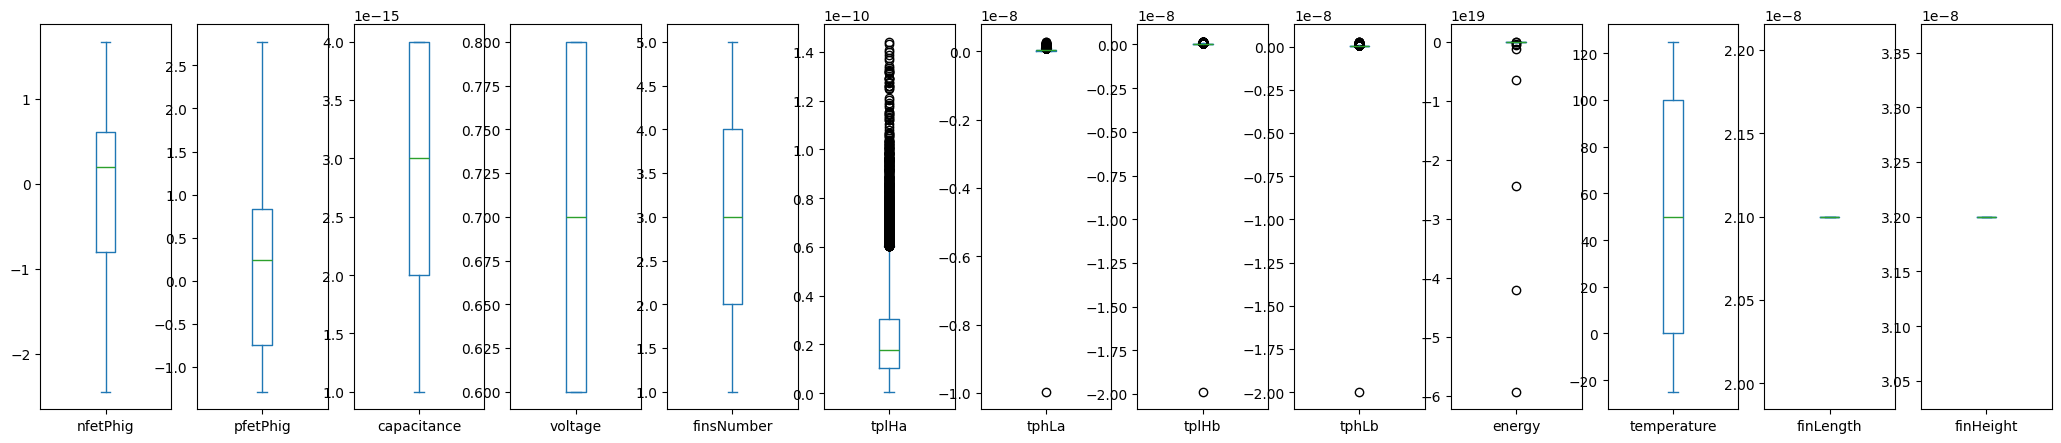

<Figure size 640x480 with 0 Axes>

In [30]:
df.plot(kind='box', figsize=(30, 5), subplots=True, layout=(1, 15))
_ = plt.figure()
plt.show()

In [31]:
df['finsNumber'].value_counts()

finsNumber
1    1622
2    1616
3    1605
5    1601
4    1599
Name: count, dtype: int64

In [32]:
df['temperature'].value_counts()

temperature
 0.0      1183
 25.0     1156
 50.0     1150
 75.0     1140
 125.0    1140
 100.0    1139
-25.0     1135
Name: count, dtype: int64

In [33]:
df.describe()

nfetPhig     pfetPhig   capacitance      voltage   finsNumber  \
count  8043.000000  8043.000000  8.043000e+03  8043.000000  8043.000000   
mean     -0.167111     0.146974  2.504662e-15     0.699428     2.992664   
std       1.024124     0.886648  1.117927e-15     0.081561     1.415205   
min      -2.450200    -1.289700  1.000000e-15     0.600000     1.000000   
25%      -0.801400    -0.744600  2.000000e-15     0.600000     2.000000   
50%       0.201400     0.245100  3.000000e-15     0.700000     3.000000   
75%       0.613100     0.836200  4.000000e-15     0.800000     4.000000   
max       1.675700     2.774200  4.000000e-15     0.800000     5.000000   

              tplHa         tphLa         tplHb         tphLb        energy  \
count  8.043000e+03  8.043000e+03  8.043000e+03  8.043000e+03  8.043000e+03   
mean   2.428877e-11  3.224740e-11  2.198128e-11  3.111367e-11 -1.672065e+16   
std    2.073116e-11  1.154051e-10  2.227530e-10  2.251354e-10  8.586175e+17   
min    5.882228e-13 -9.966564e-09 -1.986671e-08 -1.997970e-08 -5.928561e+19   
25%    1.049218e-11  1.387040e-11  1.086095e-11  1.430443e-11 -4.900464e-15   
50%    1.766384e-11  2.392020e-11  1.784293e-11  2.373189e-11 -3.604396e-15   
75%    3.040364e-11  4.166526e-11  3.095830e-11  4.188776e-11 -2.404324e-15   
max    1.441216e-10  2.743085e-10  1.534803e-10  2.746099e-10 -1.203990e-15   

       temperature     finLength     finHeight  
count  8043.000000  8.043000e+03  8.043000e+03  
mean     49.723362  2.100000e-08  3.200000e-08  
std      49.914450  9.926784e-24  1.323571e-23  
min     -25.000000  2.100000e-08  3.200000e-08  
25%       0.000000  2.100000e-08  3.200000e-08  
50%      50.000000  2.100000e-08  3.200000e-08  
75%     100.000000  2.100000e-08  3.200000e-08  
max     125.000000  2.100000e-08  3.200000e-08

## Alterando a escala

In [38]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = df.copy()
minMaxScaler = MinMaxScaler()
minMaxScaler.fit(df_scaled[["energy", "tphLa", "tplHa", "tphLb", "tplHb"]])

MinMaxScaler()

In [39]:
print(minMaxScaler.data_max_)
print(minMaxScaler.data_min_)

[-1.203990e-15  2.743085e-10  1.441216e-10  2.746099e-10  1.534803e-10]
[-5.928561e+19 -9.966564e-09  5.882228e-13 -1.997970e-08 -1.986671e-08]


In [40]:
df_scaled[["energy", "tphLa", "tplHa", "tphLb", "tplHb"]] = minMaxScaler.transform(df_scaled[["energy", "tphLa", "tplHa", "tphLb", "tplHb"]])

In [41]:
results_dir = "../../Model/results/"

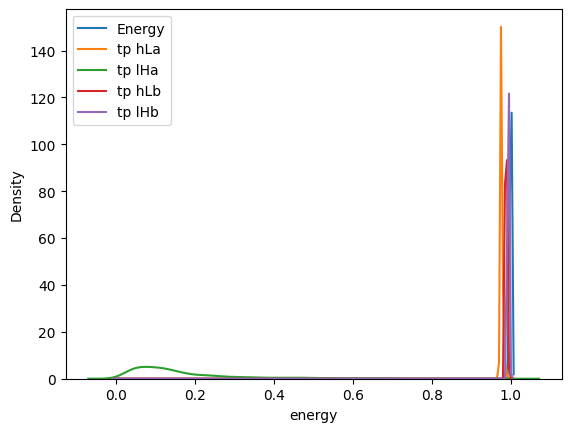

In [42]:
sns.kdeplot(df_scaled.energy, label = 'Energy')
sns.kdeplot(df_scaled.tphLa, label = 'tp hLa')
sns.kdeplot(df_scaled.tplHa, label = 'tp lHa')
sns.kdeplot(df_scaled.tphLb, label = 'tp hLb')
sns.kdeplot(df_scaled.tplHb, label = 'tp lHb')
plt.legend()
#plt.savefig(results_dir + 'normalized_targets.pdf') 
plt.show()

## Correlações

### Visualizações (demoram muito para rodar! >1h Cuidado)

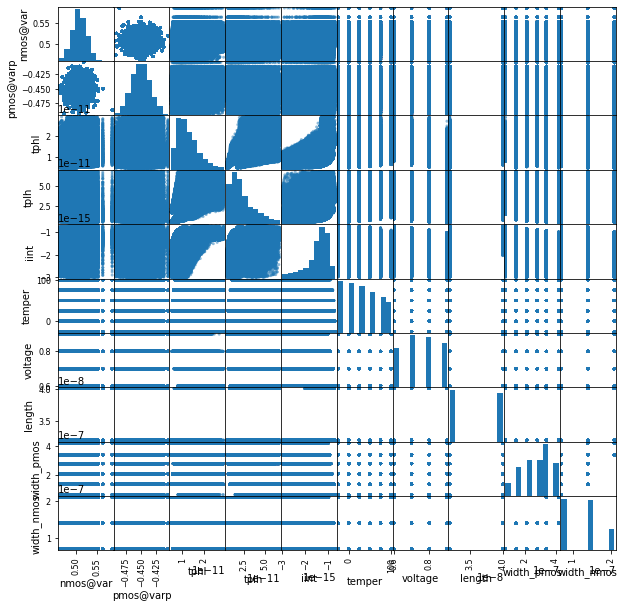

<Figure size 432x288 with 0 Axes>

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(10,10))
plt.figure()
plt.show()

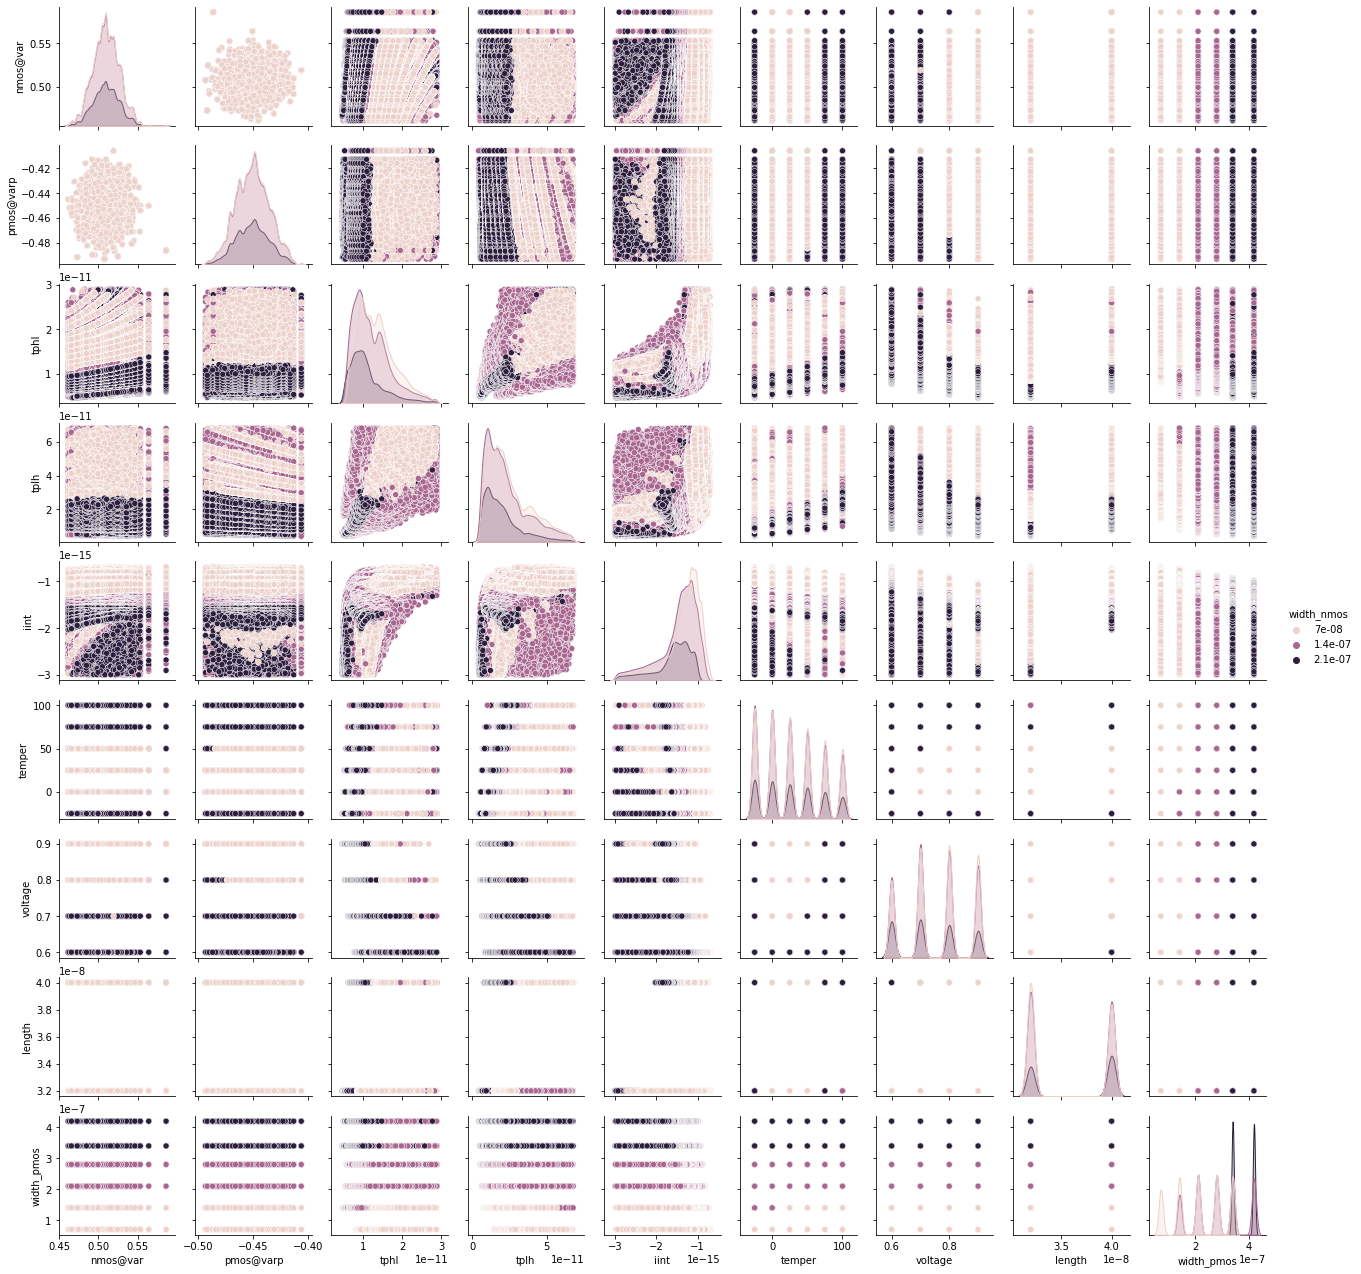

In [ ]:
_ = sns.pairplot(df, hue="width_nmos", height=2, diag_kind="kde")
plt.show()

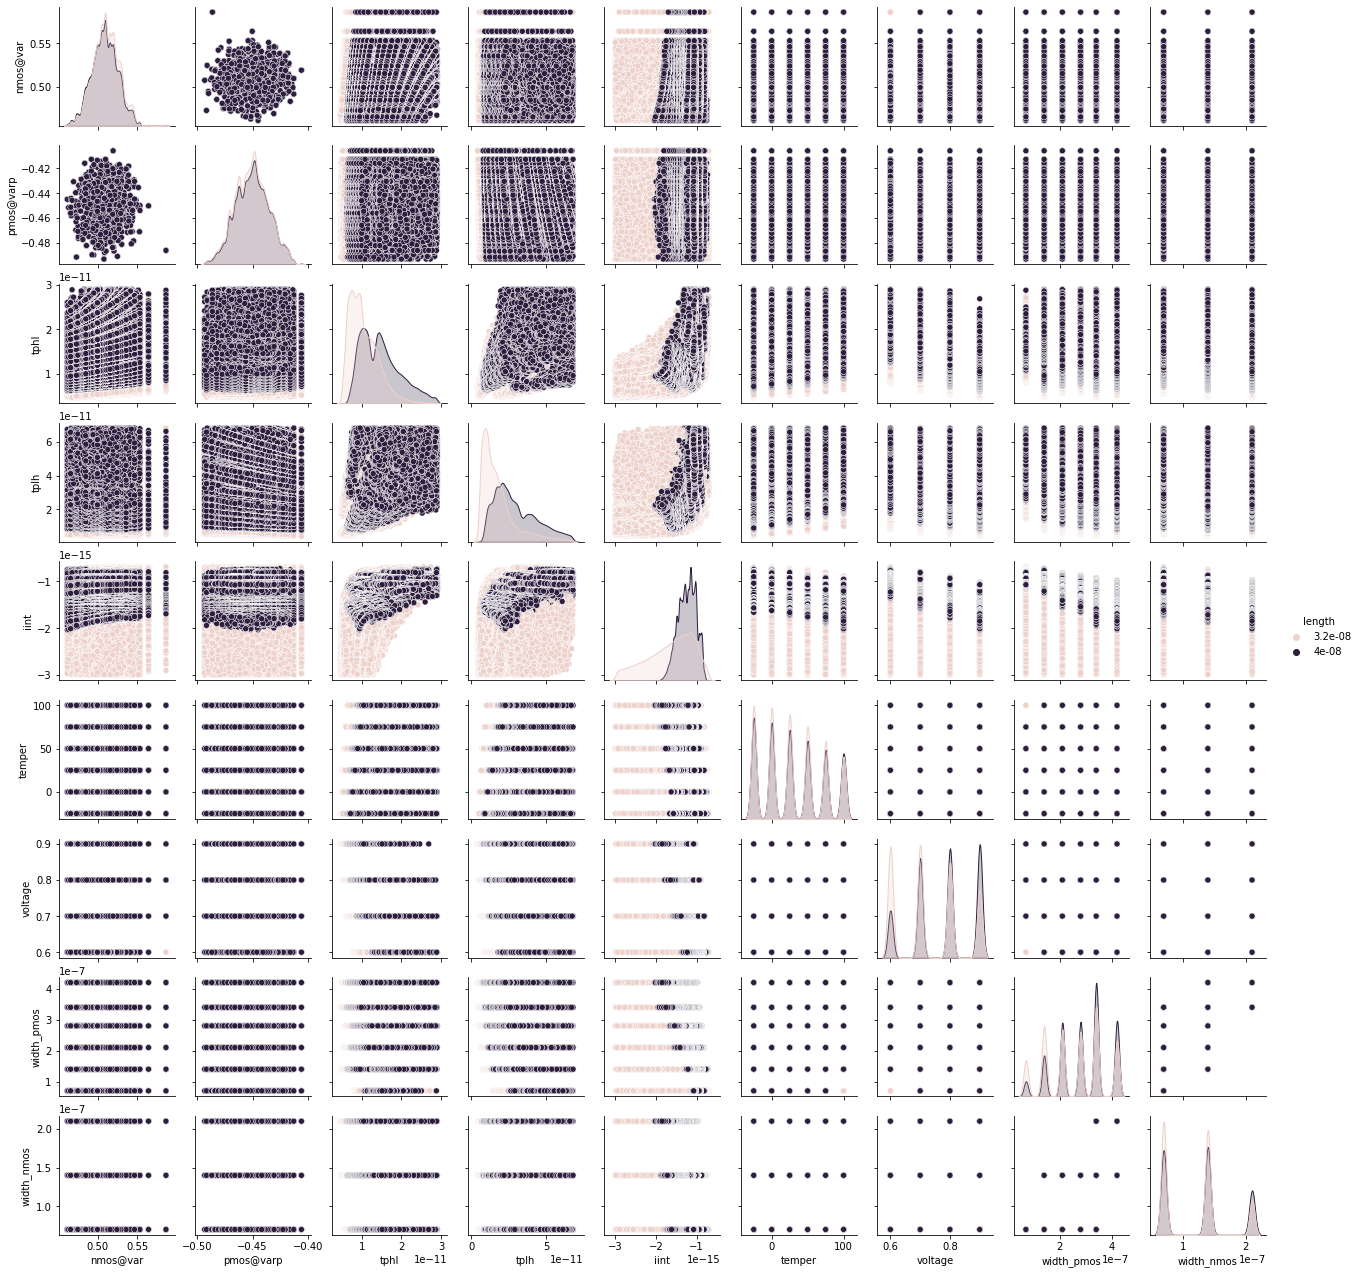

In [ ]:
_ = sns.pairplot(df, hue="length", height=2, diag_kind="kde")
plt.show()

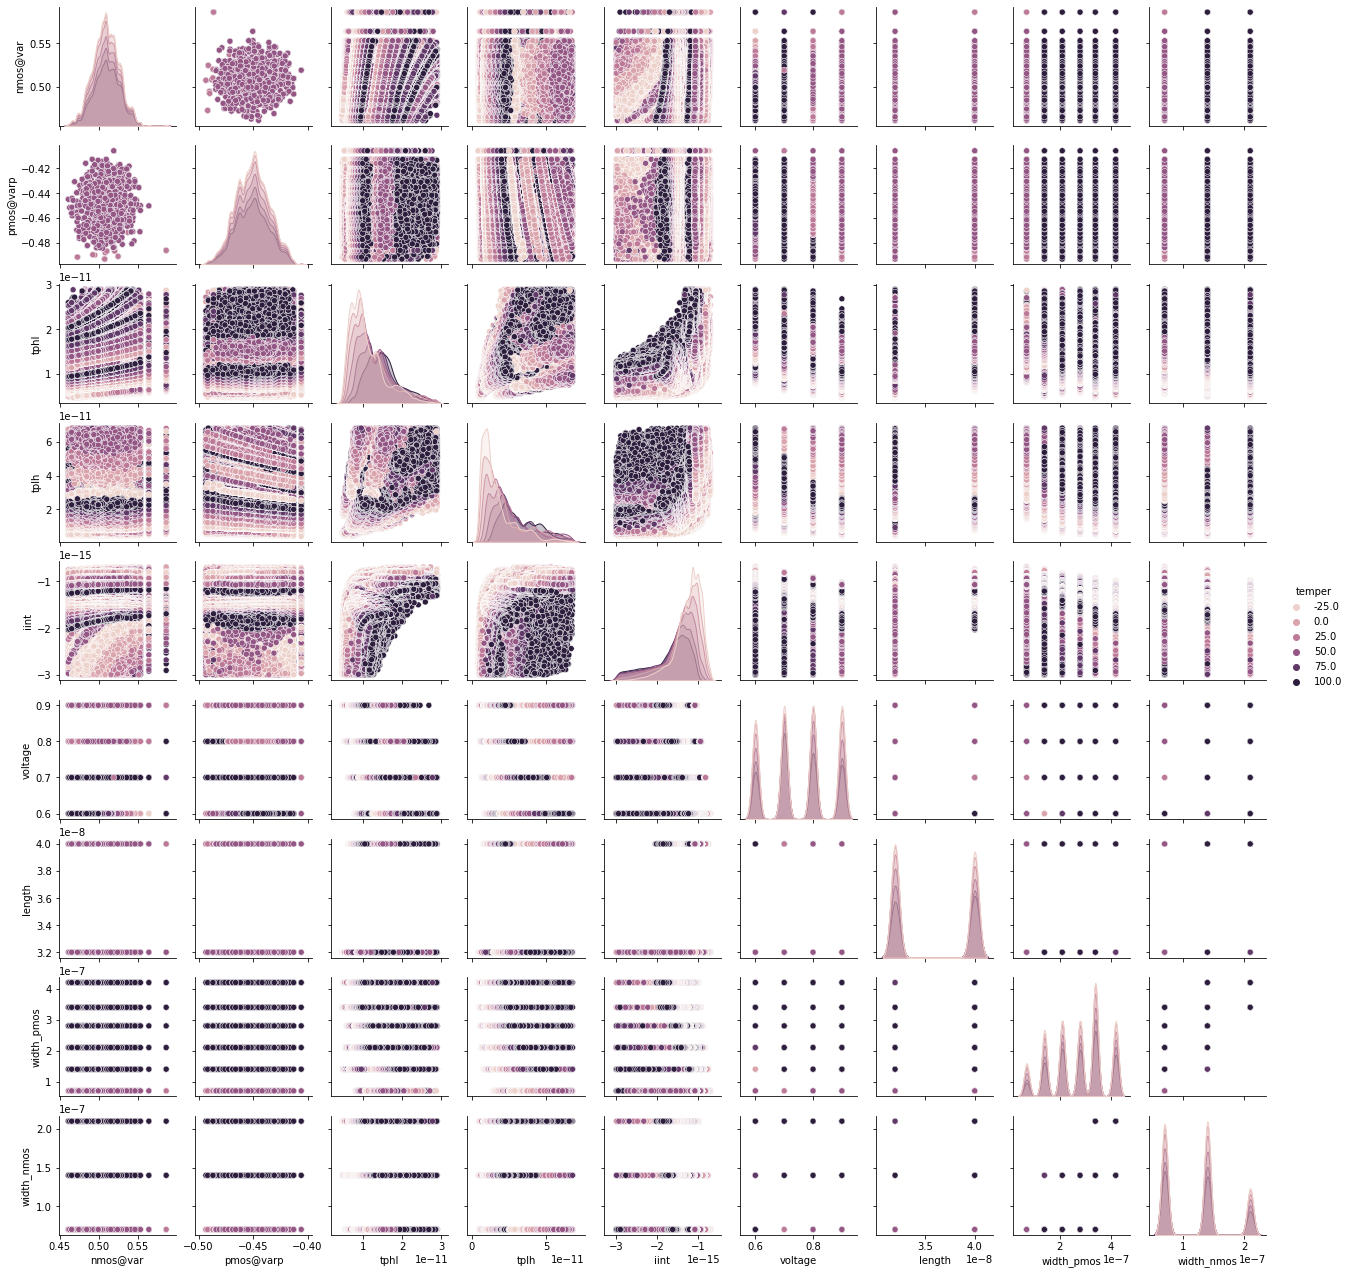

In [ ]:
_ = sns.pairplot(df, hue="temper", height=2, diag_kind="kde")
plt.show()

### Pearson

In [41]:
temp_data = df_scaled.copy()

temp_data = temp_data.drop(columns=['tphLa','tplHb'])

In [42]:
temp_data

nfetPhig  pfetPhig   capacitance  voltage  finsNumber     tplHa  \
case idx                                                                    
0    0      0.0000    0.0000  1.000000e-15      0.6           1  0.178966   
     1     -0.8014   -0.8294  1.000000e-15      0.6           1  0.212866   
     2     -0.2677    0.2150  1.000000e-15      0.6           1  0.173707   
     3      1.6757    0.8946  1.000000e-15      0.6           1  0.152850   
     4      0.2014    1.0447  1.000000e-15      0.6           1  0.149184   
...            ...       ...           ...      ...         ...       ...   
419  14     0.6131   -1.1911  4.000000e-15      0.8           5  0.107329   
     15     0.3824    0.9694  4.000000e-15      0.8           5  0.084450   
     16    -1.8849    0.6073  4.000000e-15      0.8           5  0.087614   
     17     0.8013    0.2451  4.000000e-15      0.8           5  0.093986   
     18    -1.3209    0.8362  4.000000e-15      0.8           5  0.087691   

             tphLb    energy  temperature     finLength     finHeight  
case idx                                                               
0    0    0.988310  0.985372         75.0  2.100000e-08  3.200000e-08  
     1    0.987986  0.985372         75.0  2.100000e-08  3.200000e-08  
     2    0.988190  0.985372         75.0  2.100000e-08  3.200000e-08  
     3    0.989772  0.985372         75.0  2.100000e-08  3.200000e-08  
     4    0.988497  0.985372         75.0  2.100000e-08  3.200000e-08  
...            ...       ...          ...           ...           ...  
419  14   0.987348  0.985372        -25.0  2.100000e-08  3.200000e-08  
     15   0.987322  0.985372        -25.0  2.100000e-08  3.200000e-08  
     16   0.987118  0.985372        -25.0  2.100000e-08  3.200000e-08  
     17   0.987372  0.985372        -25.0  2.100000e-08  3.200000e-08  
     18   0.987159  0.985372        -25.0  2.100000e-08  3.200000e-08  

[8052 rows x 11 columns]

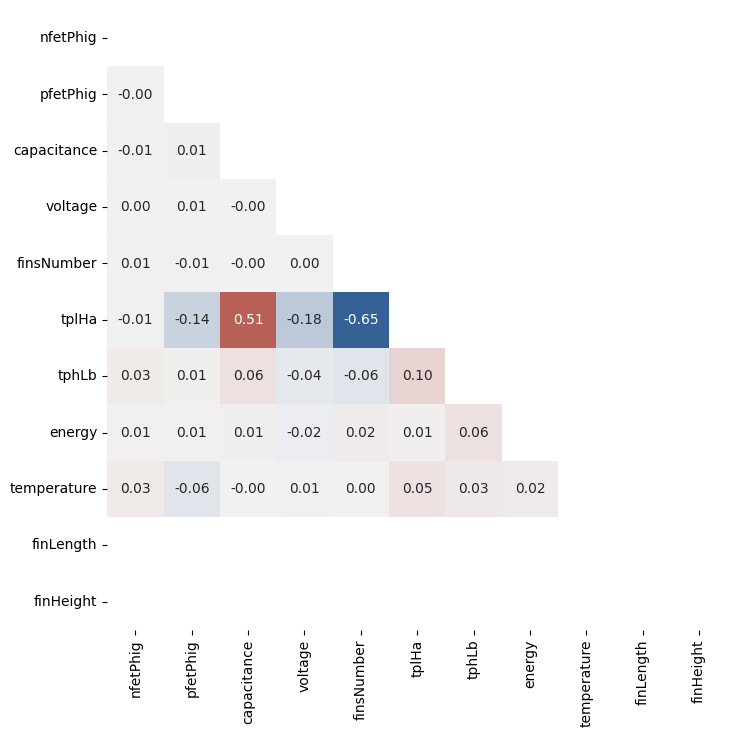

In [48]:
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(temp_data.corr(), dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(temp_data.corr(), mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)

plt.savefig(results_dir + 'pearson.pdf') 
plt.show()

### Kendall

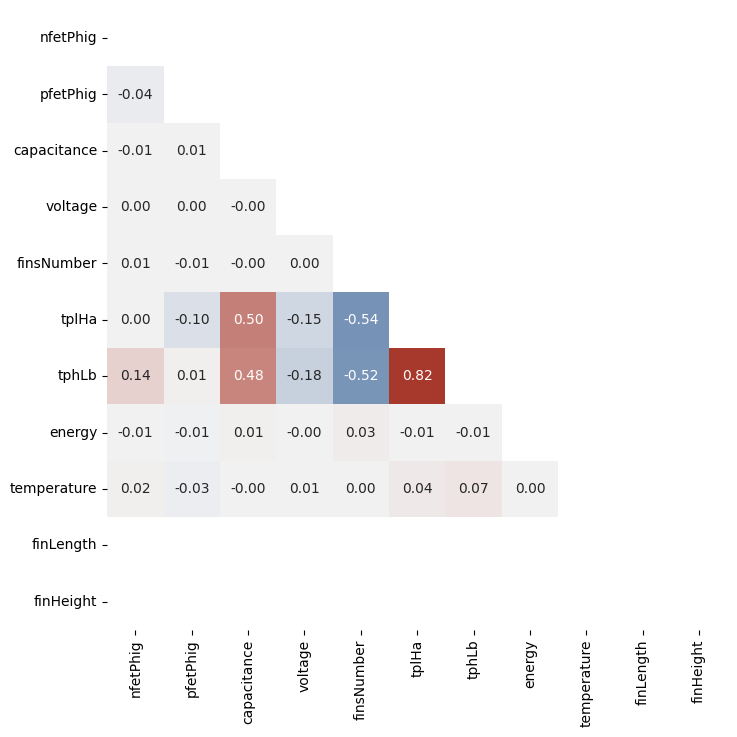

In [49]:
kendall = temp_data.corr(method='kendall')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(kendall, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(kendall, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)
plt.savefig(results_dir + 'kendall.pdf') 

plt.show()

### Spearman

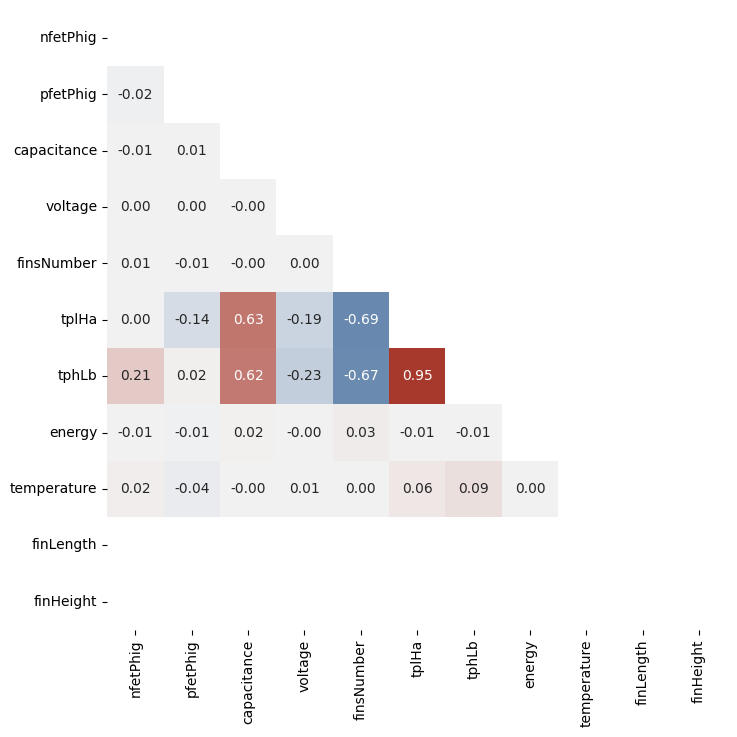

In [50]:
spearman = temp_data.corr(method='spearman')
plt.figure(figsize=(8, 11))
mask = np.triu(np.ones_like(spearman, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

sns.heatmap(spearman, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, cbar=False)
plt.savefig(results_dir + 'spearman.pdf') 

plt.show();

# Metrics

In [43]:
EPSILON = 1e-10


def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)


def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]


def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) /\
               (_error(actual[seasonality:], _naive_forecasting(actual, seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)


def _bounded_relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Bounded Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark

        abs_err = np.abs(_error(actual[seasonality:], predicted[seasonality:]))
        abs_err_bench = np.abs(_error(actual[seasonality:], _naive_forecasting(actual, seasonality)))
    else:
        abs_err = np.abs(_error(actual, predicted))
        abs_err_bench = np.abs(_error(actual, benchmark))

    return abs_err / (abs_err + abs_err_bench + EPSILON)


def _geometric_mean(a, axis=0, dtype=None):
    """ Geometric mean """
    if not isinstance(a, np.ndarray):  # if not an ndarray object attempt to convert it
        log_a = np.log(np.array(a, dtype=dtype))
    elif dtype:  # Must change the default dtype allowing array type
        if isinstance(a, np.ma.MaskedArray):
            log_a = np.log(np.ma.asarray(a, dtype=dtype))
        else:
            log_a = np.log(np.asarray(a, dtype=dtype))
    else:
        log_a = np.log(a)
    return np.exp(log_a.mean(axis=axis))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def nrmse(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())


def me(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Error """
    return np.mean(_error(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


mad = mae  # Mean Absolute Deviation (it is the same as MAE)


def gmae(actual: np.ndarray, predicted: np.ndarray):
    """ Geometric Mean Absolute Error """
    return _geometric_mean(np.abs(_error(actual, predicted)))


def mdae(actual: np.ndarray, predicted: np.ndarray):
    """ Median Absolute Error """
    return np.median(np.abs(_error(actual, predicted)))


def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(np.abs(_percentage_error(actual, predicted)))


def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def smdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Median Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.median(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


def maape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Arctangent Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.arctan(np.abs((actual - predicted) / (actual + EPSILON))))


def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))


def std_ae(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Error """
    __mae = mae(actual, predicted)
    return np.sqrt(np.sum(np.square(_error(actual, predicted) - __mae))/(len(actual) - 1))


def std_ape(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Absolute Percentage Error """
    __mape = mape(actual, predicted)
    return np.sqrt(np.sum(np.square(_percentage_error(actual, predicted) - __mape))/(len(actual) - 1))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def rmdspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Median Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.median(np.square(_percentage_error(actual, predicted))))


def rmsse(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """ Root Mean Squared Scaled Error """
    q = np.abs(_error(actual, predicted)) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))
    return np.sqrt(np.mean(np.square(q)))


def inrse(actual: np.ndarray, predicted: np.ndarray):
    """ Integral Normalized Root Squared Error """
    return np.sqrt(np.sum(np.square(_error(actual, predicted))) / np.sum(np.square(actual - np.mean(actual))))


def rrse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Relative Squared Error """
    return np.sqrt(np.sum(np.square(actual - predicted)) / np.sum(np.square(actual - np.mean(actual))))


def mre(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Error """
    return np.mean(_relative_error(actual, predicted, benchmark))


def rae(actual: np.ndarray, predicted: np.ndarray):
    """ Relative Absolute Error (aka Approximation Error) """
    return np.sum(np.abs(actual - predicted)) / (np.sum(np.abs(actual - np.mean(actual))) + EPSILON)


def mrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Relative Absolute Error """
    return np.mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mdrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Median Relative Absolute Error """
    return np.median(np.abs(_relative_error(actual, predicted, benchmark)))


def gmrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Geometric Mean Relative Absolute Error """
    return _geometric_mean(np.abs(_relative_error(actual, predicted, benchmark)))


def mbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Mean Bounded Relative Absolute Error """
    return np.mean(_bounded_relative_error(actual, predicted, benchmark))


def umbrae(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Unscaled Mean Bounded Relative Absolute Error """
    __mbrae = mbrae(actual, predicted, benchmark)
    return __mbrae / (1 - __mbrae)


def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))


METRICS = {
    'mse': mse,
    'rmse': rmse,
    'nrmse': nrmse,
    'me': me,
    'mae': mae,
    'mad': mad,
    'gmae': gmae,
    'mdae': mdae,
    'mpe': mpe,
    'mape': mape,
    'mdape': mdape,
    'smape': smape,
    'smdape': smdape,
    'maape': maape,
    'mase': mase,
    'std_ae': std_ae,
    'std_ape': std_ape,
    'rmspe': rmspe,
    'rmdspe': rmdspe,
    'rmsse': rmsse,
    'inrse': inrse,
    'rrse': rrse,
    'mre': mre,
    'rae': rae,
    'mrae': mrae,
    'mdrae': mdrae,
    'gmrae': gmrae,
    'mbrae': mbrae,
    'umbrae': umbrae,
    'mda': mda,
}


def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=('mae', 'mse', 'smape', 'umbrae')):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print('Unable to compute metric {0}: {1}'.format(name, err))
    return results


def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [44]:
from sklearn.preprocessing import Normalizer
def mape_normalized(actual, pred, plus_one = False):
  norm_actual = Normalizer().fit_transform(actual.reshape(-1, 1))
  norm_pred = Normalizer().fit_transform(pred.reshape(-1, 1))
  if plus_one:
    norm_actual = norm_actual + 1
    norm_pred = norm_pred + 1
  return mape(norm_actual, norm_pred)

# Train, Validation, Test Sets

Apenas testando para o Atraso de Descida

In [45]:
X = df_scaled.drop(columns=['tphLa', 'tplHa','tphLb', 'tplHb', 'energy'])
y = df_scaled[['tphLa', 'tplHa','tphLb', 'tplHb', 'energy']]

logging.info("X.shape: {}\n".format(X.shape))
logging.info("y.shape: {}\n".format(y.shape))
print(X.shape)
print(y.shape)

(8043, 8)
(8043, 5)


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

seed = 23

Xtr, Xte, ytr, yte = train_test_split(X, y, random_state=seed, test_size=0.25)

# grellert esse é o mais recomendado
scaler = StandardScaler().fit(Xtr)
Xtr_sc = scaler.transform(Xtr)
Xte_sc = scaler.transform(Xte)

X_train, X_val, y_train, y_val = train_test_split(Xtr_sc, ytr, random_state=seed, test_size=0.33)

logging.info("Test set X {}\n".format(Xte.shape))
logging.info("Test set y {}\n".format(yte.shape))
logging.info("Train set X {}\n".format(X_train.shape))
logging.info("Train set y {}\n".format(y_train.shape))
logging.info("Validation set X {}\n".format(X_val.shape))
logging.info("Validation set y {}\n".format(y_val.shape))

print("Test set X", Xte.shape)
print("Test set y", yte.shape)
print("Train set X", X_train.shape)
print("Train set y", y_train.shape)
print("Validation set X", X_val.shape)
print("Validation set y", y_val.shape)

Test set X (2011, 8)
Test set y (2011, 5)
Train set X (4041, 8)
Train set y (4041, 5)
Validation set X (1991, 8)
Validation set y (1991, 5)


In [47]:
y_train.describe()

tphLa        tplHa        tphLb        tplHb       energy
count  4041.000000  4041.000000  4041.000000  4041.000000  4041.000000
mean      0.976263     0.166362     0.987867     0.993318     0.999871
std       0.015637     0.146318     0.015614     0.015665     0.006708
min       0.000000     0.019009     0.000000     0.000000     0.587630
25%       0.974556     0.066908     0.987137     0.992863     1.000000
50%       0.975539     0.118481     0.987608     0.993221     1.000000
75%       0.977348     0.212450     0.988540     0.993916     1.000000
max       0.997352     0.993788     0.998789     0.999391     1.000000

# New Models


In [48]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from math import sqrt

## Shortlisting

In [73]:
clfs = [RandomForestRegressor(), LinearRegression(), SVR(kernel='rbf'), DecisionTreeRegressor()]

label: TPHL A
clf: RandomForestRegressor, mse: 2.28239260154179e-06, rmse: 0.0015107589488537838, r2: 0.7441050174442838
clf: LinearRegression, mse: 3.0646061840164492e-06, rmse: 0.0017506016634335892, r2: 0.6564055870715323
clf: SVR, mse: 0.0009092428390213014, rmse: 0.03015365382538742, r2: -100.94156792880126
clf: DecisionTreeRegressor, mse: 5.374200909986033e-08, rmse: 0.00023182322812837443, r2: 0.99397460784274
label: TPLH A
clf: RandomForestRegressor, mse: 0.00033122102539222877, rmse: 0.01819947871210131, r2: 0.9840814159806937
clf: LinearRegression, mse: 0.0055101542321224495, rmse: 0.0742304131210547, r2: 0.7351802984140035
clf: SVR, mse: 0.0028027933097558274, rmse: 0.052941413938011016, r2: 0.865296894310186
clf: DecisionTreeRegressor, mse: 0.00036064016568257824, rmse: 0.01899052831499372, r2: 0.9826675230796221
label: TPHL B
clf: RandomForestRegressor, mse: 5.109181935014058e-06, rmse: 0.0022603499585272316, r2: -1.2401076684313206
clf: LinearRegression, mse: 1.2100245914

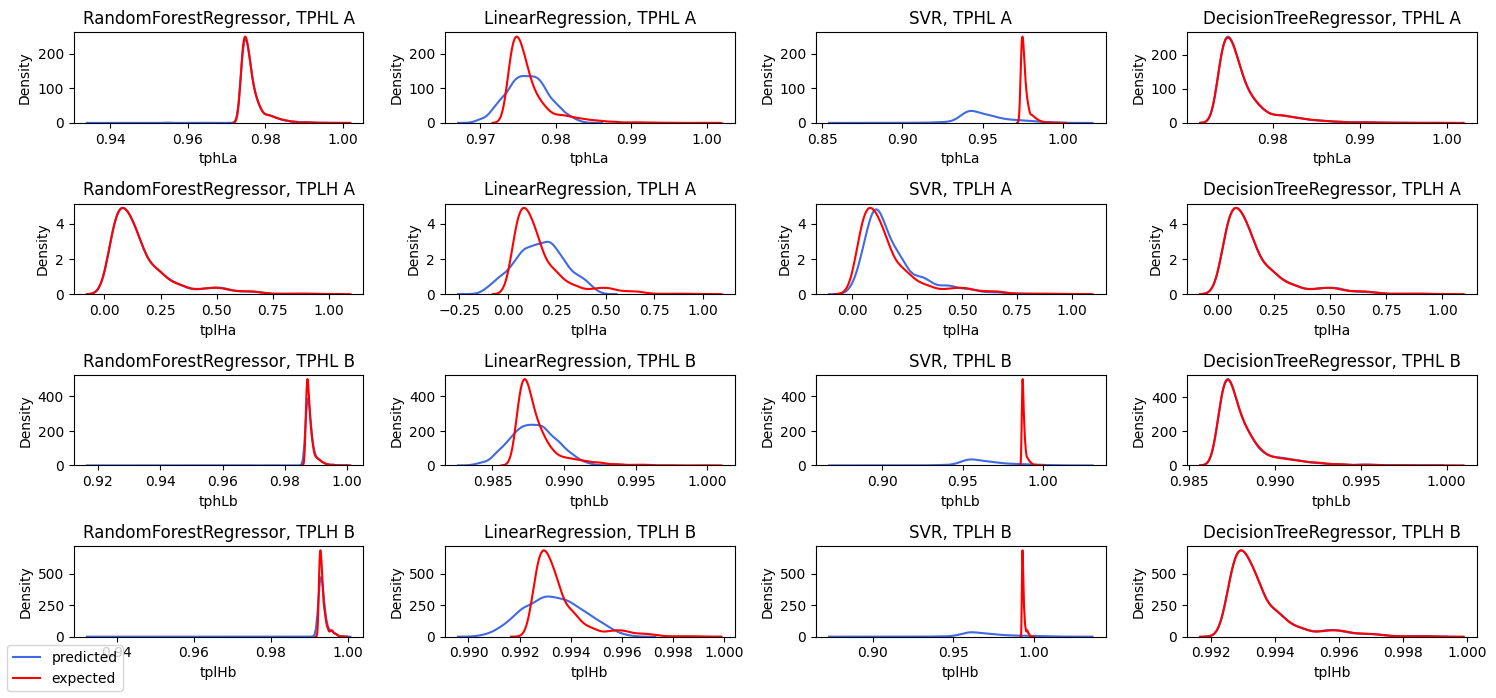

In [51]:
fig, ax = plt.subplots(4,4, figsize = (15,7))
#modelos para TPHL
print('label: TPHL A')
logging.info('label: TPHL A')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphLa)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphLa, ypred)
    r2 = r2_score(y_val.tphLa, ypred)
    mape_v0 = mape(y_val.tphLa+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphLa), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphLa), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, rmse: {sqrt(mse)}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphLa, label = 'true', ax = ax[0][i], color = 'red')
    ax[0][i].set_title(f'{clf.__class__.__name__}, TPHL A')

#modelos para TPLH
print('label: TPLH A')
logging.info('label: TPLH A')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplHa)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplHa, ypred)
    r2 = r2_score(y_val.tplHa, ypred)
    mape_v0 = mape(y_val.tplHa+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplha), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplha), ypred, True)
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, rmse: {sqrt(mse)}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplHa, label = 'true', ax = ax[1][i], color = 'red')
    ax[1][i].set_title(f'{clf.__class__.__name__}, TPLH A')

print('label: TPHL B')
logging.info('label: TPHL B')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphLb)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphLb, ypred)
    r2 = r2_score(y_val.tphLb, ypred)
    mape_v0 = mape(y_val.tphLb+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphLb), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphLb), ypred, True)
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, rmse: {sqrt(mse)}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphLb, label = 'true', ax = ax[2][i], color = 'red')
    ax[2][i].set_title(f'{clf.__class__.__name__}, TPHL B')

#modelos para TPLH
print('label: TPLH B')
logging.info('label: TPLH B')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplHb)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplHb, ypred)
    r2 = r2_score(y_val.tplHb, ypred)
    mape_v0 = mape(y_val.tplHb+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplHb), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplHb), ypred, True)
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, rmse: {sqrt(mse)}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[3][i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplHb, label = 'true', ax = ax[3][i], color = 'red')
    ax[3][i].set_title(f'{clf.__class__.__name__}, TPLH B')

    

plt.tight_layout()
fig.legend(labels=["predicted", "expected"], loc='lower left')
plt.savefig(results_dir + 'delays_nand2.pdf') 
plt.show()

label: TPHL A
clf: RandomForestRegressor, mse: 2.739605640396283e-06, r2: 0.6928436689265562
clf: LinearRegression, mse: 3.0646061840164492e-06, r2: 0.6564055870715323
clf: SVR, mse: 0.0009092428390213014, r2: -100.94156792880126
clf: DecisionTreeRegressor, mse: 5.469251338044494e-08, r2: 0.9938680401662874


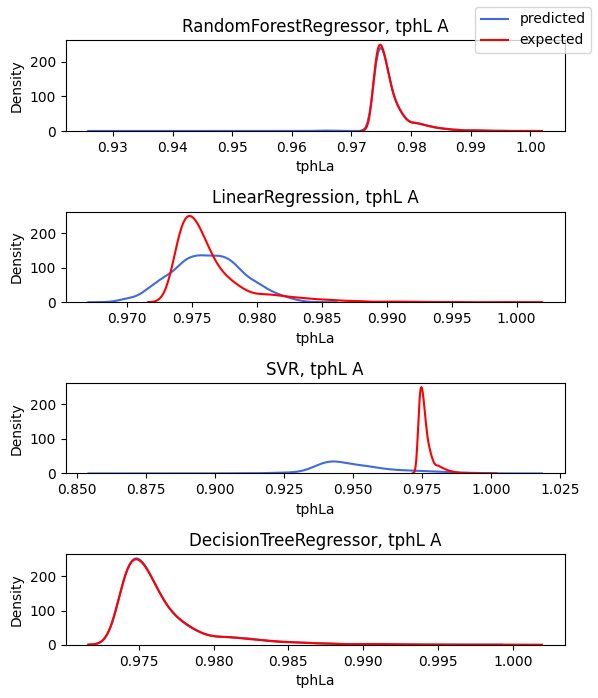

In [52]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPHLA = {}

#modelos para TPHL
print('label: TPHL A')
logging.info('label: TPHL A')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphLa)
    pred_TPHLA['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphLa, ypred)
    r2 = r2_score(y_val.tphLa, ypred)
    mape_v0 = mape(y_val.tphLa+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphLa), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphLa), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphLa, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tphL A')
    

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'tphLa_nand.pdf') 
#plt.xlim([-0.05, 0.5])
plt.show()

label: TPLH A
clf: RandomForestRegressor, mse: 0.00033158779456413876, r2: 0.9840637889418551
clf: LinearRegression, mse: 0.0055101542321224495, r2: 0.7351802984140035
clf: SVR, mse: 0.0028027933097558274, r2: 0.865296894310186
clf: DecisionTreeRegressor, mse: 0.00036007056497269464, r2: 0.9826948982643556


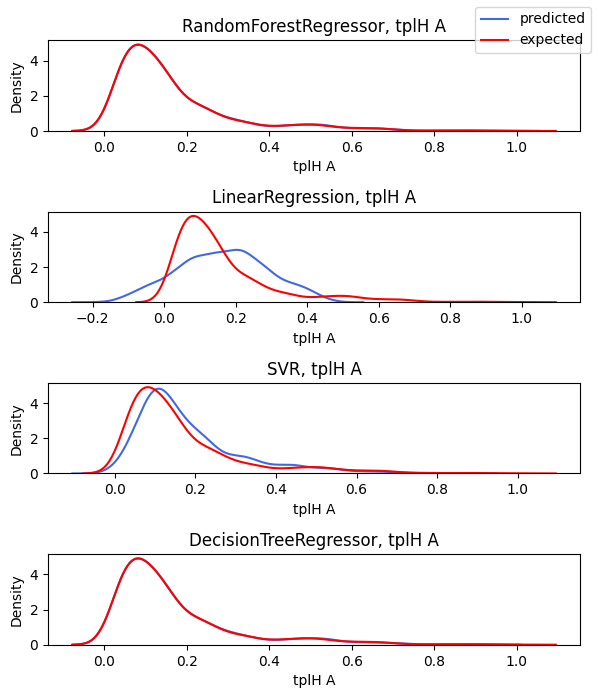

In [53]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPLH = {}
#modelos para TPLH
print('label: TPLH A')
logging.info('label: TPLH A')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplHa)
    pred_TPLH['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplHa, ypred)
    r2 = r2_score(y_val.tplHa, ypred)
    mape_v0 = mape(y_val.tplHa+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplHa), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplHa), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplHa, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tplH A')
    ax[i].set(xlabel='tplH A')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'tplHa_nand.pdf') 
plt.show()

label: TPHL B
clf: RandomForestRegressor, mse: 7.237854810830632e-06, r2: -2.173418811653575
clf: LinearRegression, mse: 1.2100245914685943e-06, r2: 0.46946783245998924
clf: SVR, mse: 0.0008548519259975643, r2: -373.80762657459735
clf: DecisionTreeRegressor, mse: 1.4336984452642924e-08, r2: 0.993713986069972


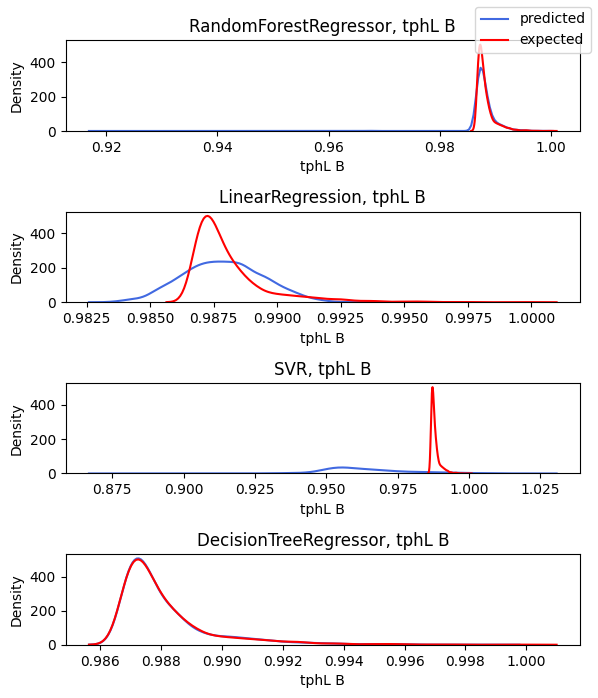

In [54]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPHL = {}
print('label: TPHL B')
logging.info('label: TPHL B')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphLb)
    pred_TPHL['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphLb, ypred)
    r2 = r2_score(y_val.tphLb, ypred)
    mape_v0 = mape(y_val.tphLb+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tphLb), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tphLb), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tphLb, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tphL B')
    ax[i].set(xlabel='tphL B')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'tphLb_nand.pdf')
plt.show()

label: TPLH B
clf: RandomForestRegressor, mse: 4.315612834639005e-06, r2: -3.1453748402831954
clf: LinearRegression, mse: 8.386760512441965e-07, r2: 0.19440720583857307
clf: SVR, mse: 0.0008196270696277292, r2: -786.2952377884105
clf: DecisionTreeRegressor, mse: 6.65536652724299e-09, r2: 0.9936071677390858


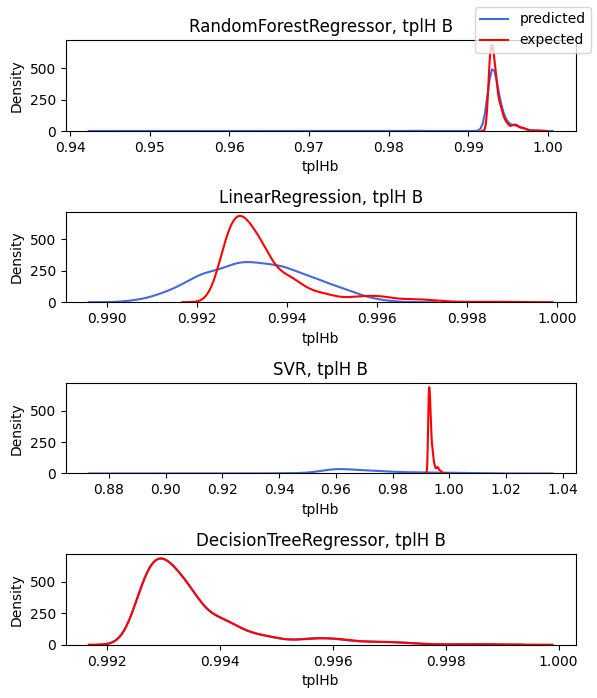

In [55]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_TPLHB = {}
#modelos para TPLH
print('label: TPLH B')
logging.info('label: TPLH B')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplHb)
    pred_TPLHB['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplHb, ypred)
    r2 = r2_score(y_val.tplHb, ypred)
    mape_v0 = mape(y_val.tplHb+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.tplHb), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.tplHb), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.tplHb, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, tplH B')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'tplHb_nand.pdf')
plt.show()

label: IINT
clf: RandomForestRegressor, mse: 0.0002618804427292804, r2: -0.03297677547993039
clf: LinearRegression, mse: 0.00025324824281212785, r2: 0.0010725866747539614
clf: SVR, mse: 0.001580352162493905, r2: -5.233634951592228
clf: DecisionTreeRegressor, mse: 0.00025364962226691876, r2: -0.0005106382909314533


/var/folders/th/7rkchd355ld00nq_2wxzxp7m0000gp/T/ipykernel_77015/3294285820.py:18: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')


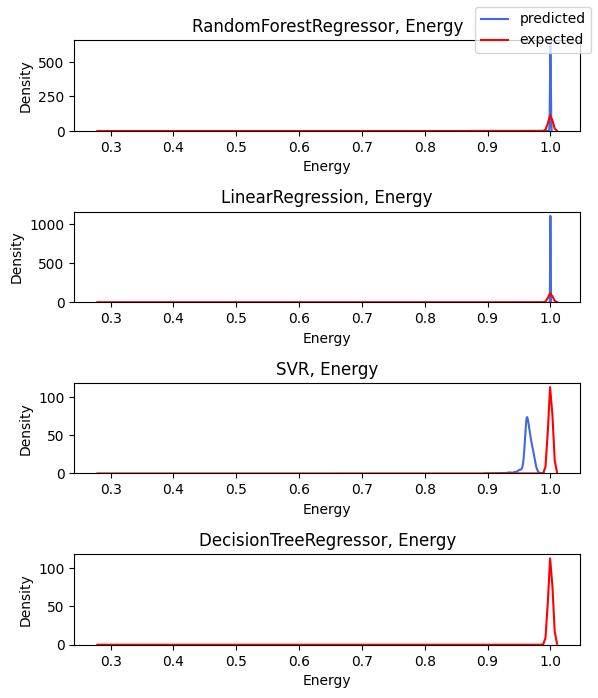

In [74]:
fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_IINT = {}
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    pred_IINT['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    mape_v0 = mape(y_val.energy+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.iint), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.iint), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[i],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[i], color = 'red')
    ax[i].set_title(f'{clf.__class__.__name__}, Energy')
    ax[i].set(xlabel='Energy')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'energy_nand.pdf')
plt.show()

label: IINT
clf: RandomForestRegressor, mse: 0.0002641359541786751, r2: -0.04187354883105221
clf: LinearRegression, mse: 0.00025324824281212785, r2: 0.0010725866747539614
clf: SVR, mse: 0.001580352162493905, r2: -5.233634951592228
clf: DecisionTreeRegressor, mse: 0.00025364962226691876, r2: -0.0005106382909314533


/var/folders/th/7rkchd355ld00nq_2wxzxp7m0000gp/T/ipykernel_77015/1326263792.py:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=ypred, label = f'{clf.__class__.__name__}', color = colors_opt[f'{clf.__class__.__name__}'])


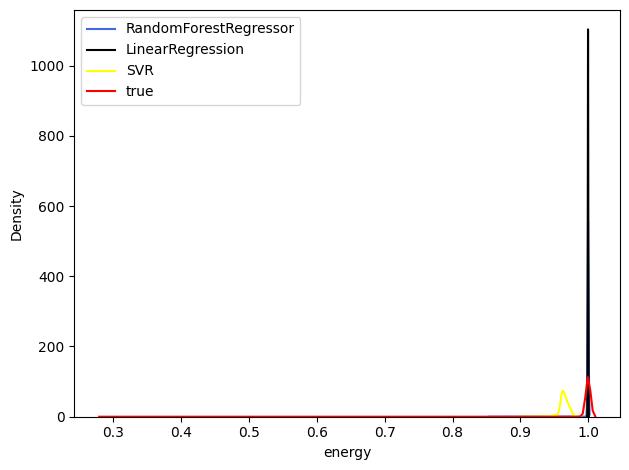

In [57]:
#fig, ax = plt.subplots(4,1, figsize = (6,7))
pred_IINT = {}
colors_opt = {'RandomForestRegressor': 'royalblue', 'LinearRegression': 'black', 'SVR': 'yellow', 'DecisionTreeRegressor': 'green'}
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    pred_IINT['{}'.format(clf.__class__.__name__)] = clf
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    mape_v0 = mape(y_val.energy+1, ypred+1)
    #mape_v1 = mape_normalized(np.array(y_val.iint), ypred)
    #mape_v2 = mape_normalized(np.array(y_val.iint), ypred, True)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = f'{clf.__class__.__name__}', color = colors_opt[f'{clf.__class__.__name__}'])

sns.kdeplot(data=y_val.energy, label = 'true', color = 'red')
plt.tight_layout()
plt.legend()
plt.savefig(results_dir + 'energy_nand.pdf')
plt.show()

# Inferencia Time

In [58]:
import time

In [59]:
test_case = X_val[1,:]

In [60]:
#def pred_time(clfs: dict, value: np.array): -> List

##TPLH
print("\n TPLH")
logging.info("\n TPLH")
for k in pred_TPLH.values():
  start_time = time.time()
  k_pred = k.predict(test_case.reshape(1, -1))
  finish_time = time.time() - start_time
  print("{}: {:.5f} secs".format(k, finish_time))
  logging.info("{}: {} secs".format(k, finish_time))


##TPHL
print("\n TPHL")
logging.info("\n TPHL")
for a in pred_TPHL.values():
  start_time = time.time()
  a_pred = a.predict(test_case.reshape(1, -1))
  finish_time = time.time() - start_time
  print("{}: {:.5f} secs".format(a.__class__.__name__, finish_time))
  logging.info("{}: {} secs".format(a.__class__.__name__, finish_time))

##IINT
print("\n IINT")
logging.info("\n IINT")
for b in pred_IINT.values():
  start_time = time.time()
  b_pred = b.predict(test_case.reshape(1, -1))
  finish_time = time.time() - start_time
  print("{}: {:.5f} secs".format(b.__class__.__name__, finish_time))
  logging.info("{}: {} secs".format(b.__class__.__name__, finish_time))

  
##TPHL
print("\n TPHLA")
for a in pred_TPHLA.values():
  start_time = time.time()
  a_pred = a.predict(test_case.reshape(1, -1))
  print("{}: {} secs".format(a.__class__.__name__, time.time() - start_time))

print("\n TPLHB")
for k in pred_TPLHB.values():
  start_time = time.time()
  k_pred = k.predict(test_case.reshape(1, -1))
  print("{}: {} secs".format(k, time.time() - start_time))


 TPLH
RandomForestRegressor(): 0.01107 secs
LinearRegression(): 0.00028 secs
SVR(): 0.00093 secs
DecisionTreeRegressor(): 0.00018 secs

 TPHL
RandomForestRegressor: 0.00381 secs
LinearRegression: 0.00013 secs
SVR: 0.00013 secs
DecisionTreeRegressor: 0.00008 secs

 IINT
RandomForestRegressor: 0.00230 secs
LinearRegression: 0.00006 secs
SVR: 0.00008 secs
DecisionTreeRegressor: 0.00006 secs

 TPHLA
RandomForestRegressor: 0.0021729469299316406 secs
LinearRegression: 5.0067901611328125e-05 secs
SVR: 7.605552673339844e-05 secs
DecisionTreeRegressor: 5.4836273193359375e-05 secs

 TPLHB
RandomForestRegressor(): 0.0026540756225585938 secs
LinearRegression(): 5.698204040527344e-05 secs
SVR(): 7.796287536621094e-05 secs
DecisionTreeRegressor(): 5.507469177246094e-05 secs


# Fine-tuning

### MLR

label: TPHL B
clf: LinearRegression, mse: 1.2100245914685943e-06, r2: 0.46946783245998924
label: TPLH A
clf: LinearRegression, mse: 0.0055101542321224495, r2: 0.7351802984140035
label: IINT
clf: LinearRegression, mse: 0.00025324824281212785, r2: 0.0010725866747539614


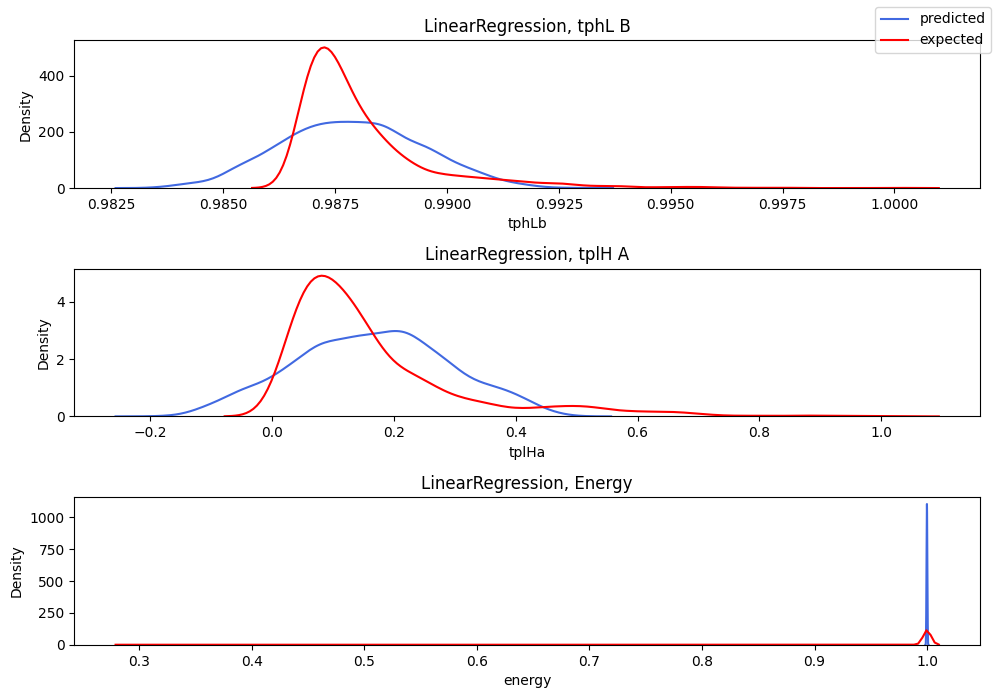

In [61]:
clfs = [LinearRegression()]
fig, ax = plt.subplots(3,1, figsize = (10,7))
logging.info("==== results_cv ====")

#modelos para TPHL
print('label: TPHL B')
logging.info('label: TPHL B')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphLb)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphLb, ypred)
    r2 = r2_score(y_val.tphLb, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphLb, label = 'true', ax = ax[0], color = 'red')
    ax[0].set_title(f'{clf.__class__.__name__}, tphL B')

#modelos para TPLH
print('label: TPLH A')
logging.info('label: TPLH A')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplHa)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplHa, ypred)
    r2 = r2_score(y_val.tplHa, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplHa, label = 'true', ax = ax[1], color = 'red')
    ax[1].set_title(f'{clf.__class__.__name__}, tplH A')

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

In [62]:
from math import sqrt

print(f"tphl = {sqrt(1.0145774357390589e-06)}, tplh = {sqrt(0.005119156817679695)}, energy = {sqrt(0.0002458065783639853)}")

tphl = 0.0010072623470273566, tplh = 0.07154828312181709, energy = 0.015678219872293706


### Decision Tree

In [63]:
params = {'max_depth': [1, 2, 4, 8, 16, 32, 64, 128]}
          #'max_features': [2, 5, 7],
          #'min_samples_split': [2, 8, 15, 30],}

DF_model_cv_gs = DecisionTreeRegressor(random_state=seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(DF_model_cv_gs, param_grid=params, scoring= "r2",return_train_score=True, cv =10) # valor padrão para quebras é 3
logging.info("\n ==== hyperparameters (cv = 10)====")

##### TPHL ####
grid_search.fit(Xtr, ytr.tphLb)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
DF_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPHL[DF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplHa)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
DF_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_TPLH[DF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))


#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters (Energy):')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
DF_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     DF_cv_results_iint[DF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))


 Best hyperparameters:
{'max_depth': 1}
Average Score on train set: 0.045 +/- 0.128
Average Score on validation set: 0.259 +/- 0.091

 Best hyperparameters:
{'max_depth': 4}
Average Score on train set: 0.609 +/- 0.003
Average Score on validation set: 0.588 +/- 0.031

 Best hyperparameters (Energy):
{'max_depth': 8}
Average Score on train set: 0.990 +/- 0.009
Average Score on validation set: 0.299 +/- 0.459


label: TPHL B
clf: DecisionTreeRegressor, mse: 2.2226199567182916e-06, r2: 0.02549800097509436
label: TPLH A
clf: DecisionTreeRegressor, mse: 0.0019987163551862335, r2: 0.9039410792442394
label: IINT
clf: DecisionTreeRegressor, mse: 0.00033905856139639497, r2: -0.3374027315669892


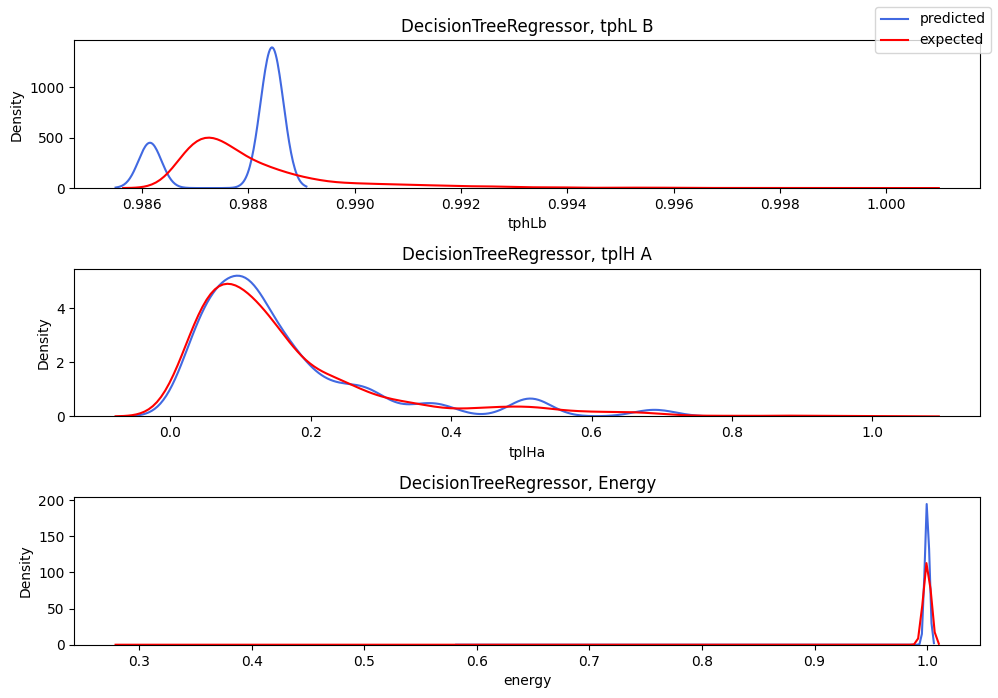

In [64]:
clfs = [DecisionTreeRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("==== results_cv ====")

#modelos para TPHL
print('label: TPHL B')
logging.info('label: TPHL B')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 1)
    clf = clf.fit(X_train, y_train.tphLb)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphLb, ypred)
    r2 = r2_score(y_val.tphLb, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphLb, label = 'true', ax = ax[0], color = 'red')
    ax[0].set_title(f'{clf.__class__.__name__}, tphL B')

#modelos para TPLH
print('label: TPLH A')
logging.info('label: TPLH A')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 4)
    clf = clf.fit(X_train, y_train.tplHa)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplHa, ypred)
    r2 = r2_score(y_val.tplHa, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplHa, label = 'true', ax = ax[1], color = 'red')
    ax[1].set_title(f'{clf.__class__.__name__}, tplH A')

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(max_depth = 8)
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'DT_all_best_hyperparams_nand.pdf')
plt.show()


In [87]:
print(f"tphl = {sqrt(6.591986190363553e-06)}, tplh = {sqrt(0.001003713387338599)}, energy = {sqrt(0.0002552897227937332)}")

tphl = 0.002567486356412348, tplh = 0.03168143600499509, energy = 0.015977788419982698


### Random Forest

In [65]:
params = {'n_estimators': [1, 2, 3, 4, 5, 50, 75, 85, 95, 100],
          'max_depth': [1, 2, 4, 8, 16, 32, 64, 128]}
          #'max_features': [2, 5, 7],
          #'min_samples_split': [2, 8, 15, 30],}

RF_model_cv_gs = RandomForestRegressor(random_state=seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(RF_model_cv_gs, param_grid=params, scoring= "r2",return_train_score=True, cv =10) # valor padrão para quebras é 3
logging.info("\n ==== hyperparameters (cv = 10)====")

##### TPHL ####
grid_search.fit(Xtr, ytr.tphLb)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
RF_cv_results_TPHL = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPHL[RF_cv_results_TPHL.rank_test_score == 1].std_test_score.values[0]))

#### TPLH ####
grid_search.fit(Xtr, ytr.tplHa)
print('\n Best hyperparameters:')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
RF_cv_results_TPLH = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_TPLH[RF_cv_results_TPLH.rank_test_score == 1].std_test_score.values[0]))


#### IINT ####
grid_search.fit(Xtr, ytr.energy)
print('\n Best hyperparameters (Energy):')
logging.info('\n Best hyperparameters:')
print(grid_search.best_params_)
logging.info(grid_search.best_params_)
RF_cv_results_iint = pd.DataFrame(grid_search.cv_results_)
print("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))
logging.info("Average Score on train set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_train_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_train_score.values[0]))
logging.info("Average Score on validation set: {:.3f} +/- {:.3f}".format(RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].mean_test_score.values[0],
                                                                     RF_cv_results_iint[RF_cv_results_iint.rank_test_score == 1].std_test_score.values[0]))


 Best hyperparameters:
{'max_depth': 1, 'n_estimators': 50}
Average Score on train set: 0.046 +/- 0.127
Average Score on validation set: 0.316 +/- 0.110

 Best hyperparameters:
{'max_depth': 4, 'n_estimators': 95}
Average Score on train set: 0.615 +/- 0.003
Average Score on validation set: 0.598 +/- 0.029

 Best hyperparameters (Energy):
{'max_depth': 8, 'n_estimators': 1}
Average Score on train set: 0.907 +/- 0.221
Average Score on validation set: 0.399 +/- 0.490


In [66]:
RF_cv_results_TPHL.to_csv(results_dir + 'RF_TPHLB_HyperParameters.csv')

In [67]:
RF_cv_results_TPLH.to_csv(results_dir + 'RF_TPLHA_HyperParameters.csv')

In [68]:
RF_cv_results_iint.to_csv(results_dir + 'RF_Energy_HyperParameters.csv')

In [69]:
RF_cv_results_iint.describe()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
count      80.000000     80.000000        80.000000       80.000000   
mean        0.042150      0.002722         0.001444        0.000230   
std         0.040464      0.004633         0.000806        0.000758   
min         0.001680      0.000045         0.000553        0.000017   
25%         0.003963      0.000292         0.000627        0.000048   
50%         0.026946      0.001355         0.001521        0.000080   
75%         0.084780      0.003215         0.002172        0.000145   
max         0.112925      0.032169         0.003523        0.006262   

       param_max_depth  param_n_estimators  split0_test_score  \
count        80.000000           80.000000          80.000000   
mean         31.875000           42.000000           0.125000   
std          41.669093           41.234126           0.332805   
min           1.000000            1.000000           0.000000   
25%           3.500000            3.000000           0.000000   
50%          12.000000           27.500000           0.000000   
75%          40.000000           85.000000           0.000000   
max         128.000000          100.000000           1.000000   

       split1_test_score  split2_test_score  split3_test_score  ...  \
count               80.0               80.0          80.000000  ...   
mean                 0.0                0.0           0.625000  ...   
std                  0.0                0.0           0.487177  ...   
min                  0.0                0.0           0.000000  ...   
25%                  0.0                0.0           0.000000  ...   
50%                  0.0                0.0           1.000000  ...   
75%                  0.0                0.0           1.000000  ...   
max                  0.0                0.0           1.000000  ...   

       split2_train_score  split3_train_score  split4_train_score  \
count           80.000000           80.000000           80.000000   
mean             0.538611            0.534362            0.534211   
std              0.365119            0.362533            0.362788   
min              0.001193            0.001187            0.001230   
25%              0.132107            0.131749            0.132209   
50%              0.698899            0.694707            0.694766   
75%              0.850935            0.846286            0.846530   
max              0.999856            0.982632            0.982776   

       split5_train_score  split6_train_score  split7_train_score  \
count           80.000000           80.000000           80.000000   
mean             0.587698            0.571250            0.543193   
std              0.388451            0.379698            0.369369   
min              0.001378            0.000233            0.000362   
25%              0.217031            0.102884            0.108617   
50%              0.788323            0.774907            0.778412   
75%              0.942026            0.838859            0.800259   
max              0.967305            0.999951            0.982729   

       split8_train_score  split9_train_score  mean_train_score  \
count           80.000000           80.000000         80.000000   
mean             0.539723            0.543012          0.535046   
std              0.348858            0.369535          0.349218   
min              0.001048            0.000542          0.001524   
25%              0.241725            0.098683          0.176986   
50%              0.771222            0.796394          0.743594   
75%              0.779002            0.799249          0.802401   
max              0.977050            0.982729          0.907250   

       std_train_score  
count        80.000000  
mean          0.065550  
std           0.066827  
min           0.000344  
25%           0.020825  
50%           0.035955  
75%           0.111981  
max           0.220652  

[8 rows x 31 columns]

label: TPHL B
clf: RandomForestRegressor, mse: 1.5318570478241165e-06, r2: 0.3283612203639552
label: TPLH A
clf: RandomForestRegressor, mse: 0.001704240172861515, r2: 0.9180936948412401
label: IINT
clf: RandomForestRegressor, mse: 0.00025364962226691876, r2: -0.0005106382909314533


/var/folders/th/7rkchd355ld00nq_2wxzxp7m0000gp/T/ipykernel_77015/3336525926.py:56: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')


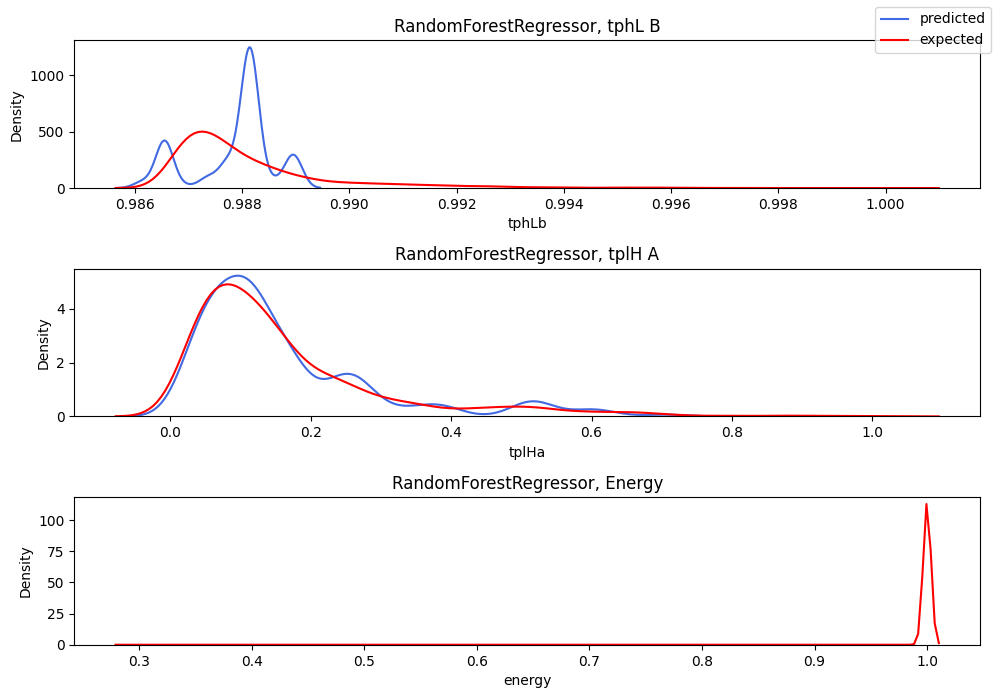

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [70]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("==== results_cv ====")

#modelos para TPHL
print('label: TPHL B')
logging.info('label: TPHL B')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 50,
                   max_depth = 1)
    clf = clf.fit(X_train, y_train.tphLb)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphLb, ypred)
    r2 = r2_score(y_val.tphLb, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphLb, label = 'true', ax = ax[0], color = 'red')
    ax[0].set_title(f'{clf.__class__.__name__}, tphL B')

#modelos para TPLH
print('label: TPLH A')
logging.info('label: TPLH A')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 95,
                   max_depth = 4)
    clf = clf.fit(X_train, y_train.tplHa)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplHa, ypred)
    r2 = r2_score(y_val.tplHa, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplHa, label = 'true', ax = ax[1], color = 'red')
    ax[1].set_title(f'{clf.__class__.__name__}, tplH A')

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 1,
                   max_depth = 8)
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()



"""Bizarro, o TPHL roda melhor se botar o max-depth como 10 e não 5 o cv mostrou. Dumb, é devido ao overfit"""



"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

In [88]:
print(f"tphl = {sqrt(1.0232111898932257e-05)}, tplh = {sqrt(0.000820747431054089)}, energy = {sqrt(0.00025872154979468)}")

tphl = 0.0031987672467580783, tplh = 0.028648689866276417, energy = 0.016084823586060247


label: IINT
clf: RandomForestRegressor, mse: 0.0002488333630689412, r2: -0.011723449342049053


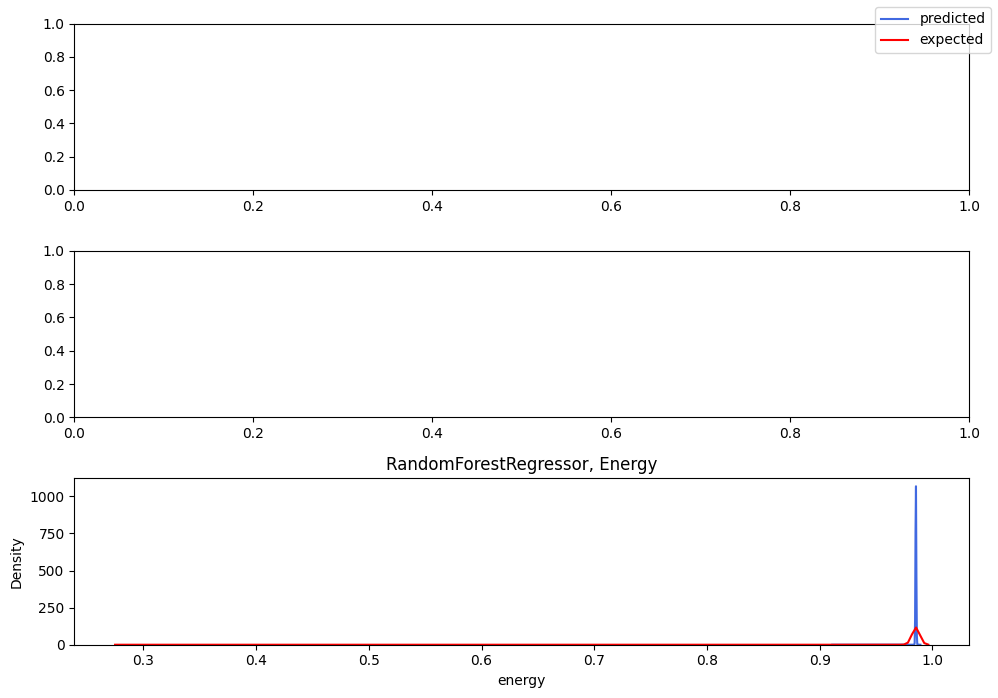

In [81]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("==== results_test_set ====")

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf.set_params(n_estimators = 50,
                   max_depth = 10)
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

In [82]:
y_scal_pred = SVR_model_cv_gs.predict(X_scal_test)

NameError: name 'SVR_model_cv_gs' is not defined

In [ ]:
print(np.concatenate((y_scal_pred.reshape(len(y_scal_pred),3), y_scal_test.reshape(len(y_scal_test),3)), axis=1))

clf: RandomForestRegressor, mse: 0.00016496673614423653, r2: 0.9975684859133309


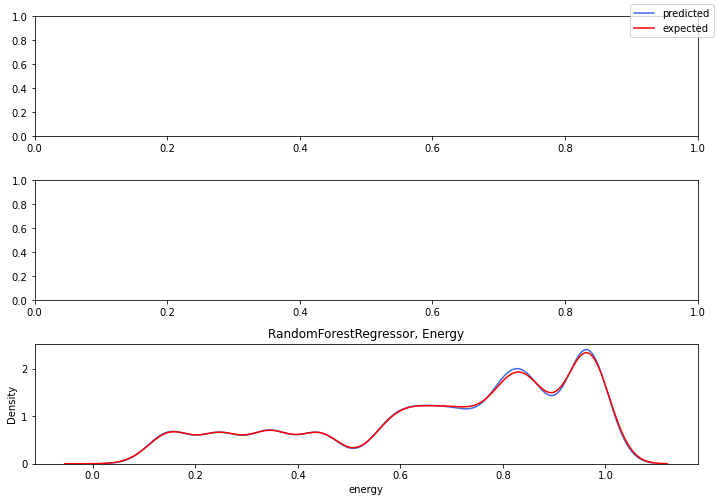

In [ ]:
clfs = [RandomForestRegressor(random_state = seed)]
fig, ax = plt.subplots(3,1, figsize = (10,7))

clf.set_params(n_estimators = 50,
                   max_depth = 4)
clf = clf.fit(X_train, y_train.energy)
ypred = clf.predict(X_val)
mse = mean_squared_error(y_val.energy, ypred)
r2 = r2_score(y_val.energy, ypred)

sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
ax[2].set_title(f'{clf.__class__.__name__}, Energy')
print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()



In [ ]:
pd.Series(ypred).unique()

array([0.62786472, 0.80429493, 0.57713335, 0.97341263, 0.72781428,
       0.85749034, 0.95619559, 0.24227886, 0.67773463, 0.44862054,
       0.15883016, 0.35088958, 0.14120046, 0.33834697, 0.43928195,
       0.34590076, 0.43846087, 0.25526333, 0.24083394, 0.143682  ])

In [ ]:
pd.DataFrame(ypred).to_csv("./predito")
pd.DataFrame(y_val.energy).to_csv("./esperado")

label: IINT
clf: RandomForestRegressor, mse: 0.004011302774255962, r2: 0.9408269149306446


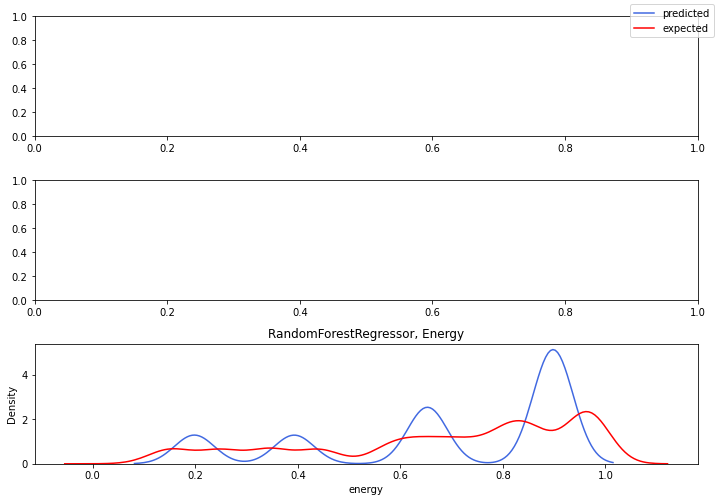

In [ ]:
fig, ax = plt.subplots(3,1, figsize = (10,7))

clf.set_params(n_estimators = 50,
                   max_depth = 2)
clf = clf.fit(Xtr_sc, ytr.energy)
ypred = clf.predict(Xte_sc)
mse = mean_squared_error(yte.energy, ypred)
r2 = r2_score(yte.energy, ypred)
print('label: IINT')
print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

### SVR RBF

label: TPHL B
clf: SVR, mse: 0.0009470281275632327, r2: -440.07813424245546
label: TPLH A
clf: SVR, mse: 0.0024386115796911135, r2: 0.8774481767665314
label: IINT
clf: SVR, mse: 0.0011616057537541166, r2: -3.722934921062337


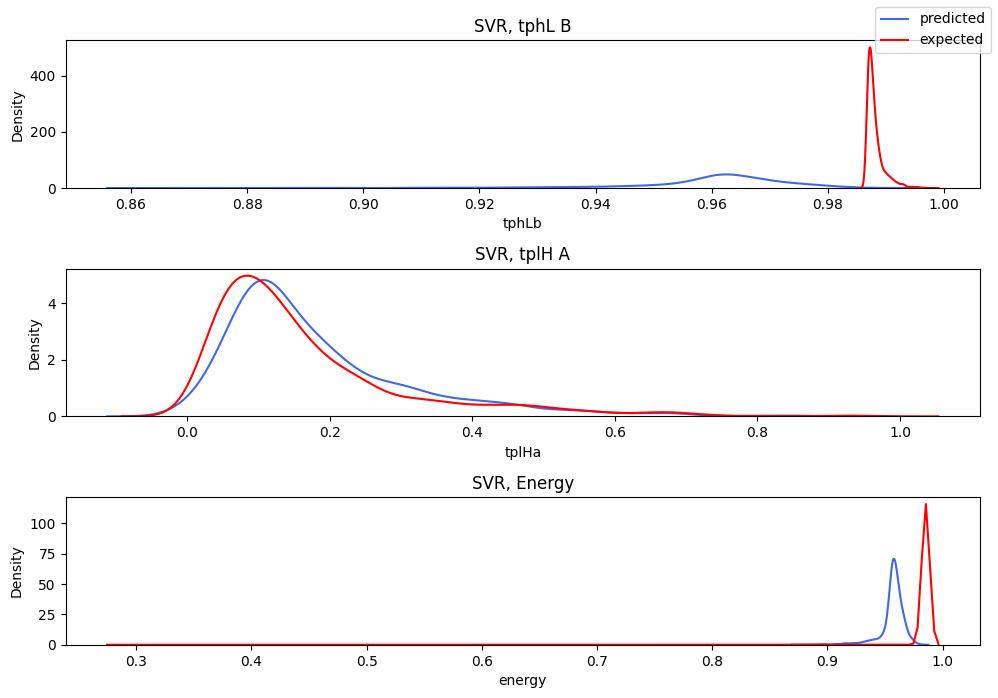

In [83]:
clfs = [SVR(kernel='rbf')]
fig, ax = plt.subplots(3,1, figsize = (10,7))

logging.info("==== results_cv ====")

#modelos para TPHL
print('label: TPHL B')
logging.info('label: TPHL B')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tphLb)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tphLb, ypred)
    r2 = r2_score(y_val.tphLb, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[0],color = 'royalblue')
    sns.kdeplot(data=y_val.tphLb, label = 'true', ax = ax[0], color = 'red')
    ax[0].set_title(f'{clf.__class__.__name__}, tphL B')

#modelos para TPLH
print('label: TPLH A')
logging.info('label: TPLH A')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.tplHa)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.tplHa, ypred)
    r2 = r2_score(y_val.tplHa, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[1],color = 'royalblue')
    sns.kdeplot(data=y_val.tplHa, label = 'true', ax = ax[1], color = 'red')
    ax[1].set_title(f'{clf.__class__.__name__}, tplH A')

#modelos para IINT
print('label: IINT')
logging.info('label: IINT')
for idx,clf in enumerate(clfs):
    i = idx
    clf = clf.fit(X_train, y_train.energy)
    ypred = clf.predict(X_val)
    mse = mean_squared_error(y_val.energy, ypred)
    r2 = r2_score(y_val.energy, ypred)
    print(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2}')
    logging.info(f'clf: {clf.__class__.__name__}, mse: {mse}, r2: {r2} (max_depth = 4)')
    
    sns.kdeplot(data=ypred, label = 'predicted', ax = ax[2],color = 'royalblue')
    sns.kdeplot(data=y_val.energy, label = 'true', ax = ax[2], color = 'red')
    ax[2].set_title(f'{clf.__class__.__name__}, Energy')

plt.tight_layout()
fig.legend(labels=["predicted", "expected"])
plt.savefig(results_dir + 'RF_all_best_hyperparams_nand.pdf')
plt.show()

In [89]:
print(f"tphl = {sqrt(0.0009470281275632327)}, tplh = {sqrt(0.0024386115796911135)}, energy = {sqrt(0.0011616057537541166)}")

tphl = 0.030773822114960513, tplh = 0.04938230026731352, energy = 0.03408233785634601


# Neural Networks

In [ ]:
import tensorflow as tf

## Neural Net #0 (Try hard mode)

In [ ]:
ann = tf.keras.models.Sequential()

In [ ]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer='adam', loss='mean_squared_error')

###**TPHL**

In [ ]:
ann.fit(X_train,y_train.tphl, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 0.0054
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.3023e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3005e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.0970e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 9.3712e-05
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.6630e-05
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.4781e-05
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.2229e-05
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 8.0173e-05
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.6979e-05
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 7.4878e-05
Epoch 12/50
5777/5777 [======================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.tphl, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 5.659724973517145e-05


Text(0.5, 1.0, 'ANN, TPHL')

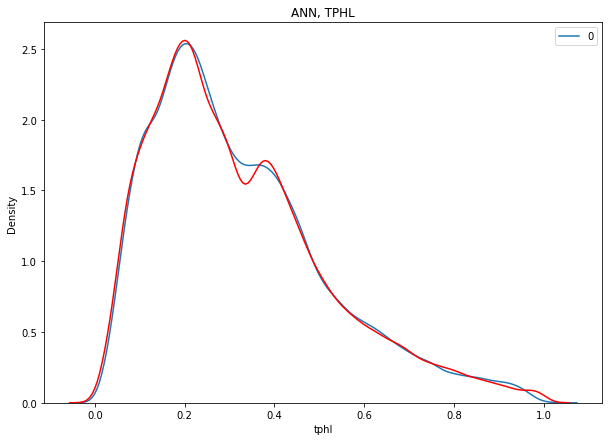

In [ ]:
fig_tphl, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tphl, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, TPHL')

###**TPLH**

In [ ]:
ann.fit(X_train,y_train.tplh, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 5.3271e-04
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.6928e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.5479e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4872e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4467e-04
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.4033e-04
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3642e-04
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3444e-04
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3278e-04
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3065e-04
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 1.3020e-04
Epoch 12/50
5777/5777 [==================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.tplh, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 0.00010841889629696702


Text(0.5, 1.0, 'ANN, TPLH')

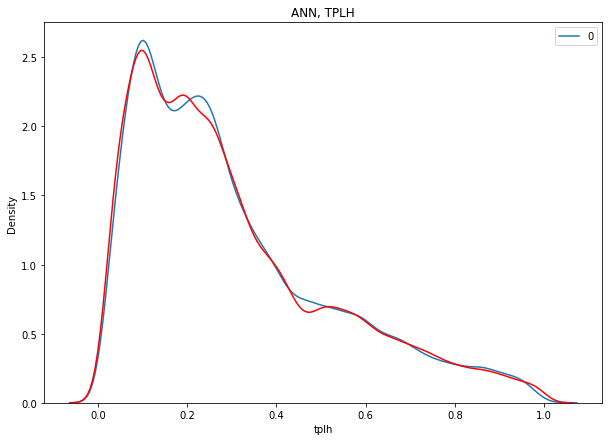

In [ ]:
fig_tplh, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tplh, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, TPLH')

###**IINT**

In [ ]:
ann.fit(X_train,y_train.iint, batch_size=40, epochs=50)

Epoch 1/50
5777/5777 [==============================] - 7s 1ms/step - loss: 0.0015
Epoch 2/50
5777/5777 [==============================] - 7s 1ms/step - loss: 3.2178e-04
Epoch 3/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.9526e-04
Epoch 4/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.8470e-04
Epoch 5/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.7587e-04
Epoch 6/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.7122e-04
Epoch 7/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6758e-04
Epoch 8/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6661e-04
Epoch 9/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.6319e-04
Epoch 10/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.5917e-04
Epoch 11/50
5777/5777 [==============================] - 7s 1ms/step - loss: 2.4992e-04
Epoch 12/50
5777/5777 [======================

In [ ]:
ypred = ann.predict(X_val)
mse = mean_squared_error(y_val.iint, ypred)
print(f'clf: ANN, mse: {mse}')

clf: ANN, mse: 0.00016256548097748116


Text(0.5, 1.0, 'ANN, IINT')

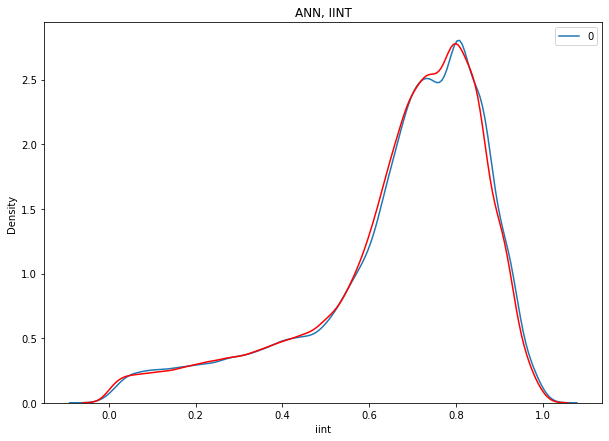

In [ ]:
fig_iint, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=ypred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.iint, label = 'true', ax = ax, color = 'red')
ax.set_title('ANN, IINT')

## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100, ),
                                    early_stopping = True, )

###TPHL

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.tphl, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0012760736147303222


Text(0.5, 1.0, 'MLP, TPHL')

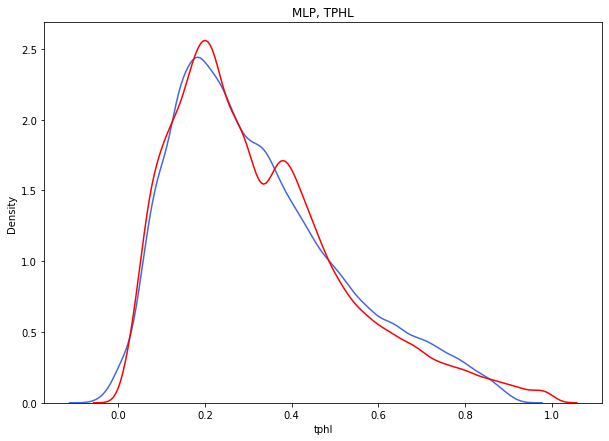

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tphl, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, TPHL')

Score on training set: 0.967
Score on validation set: 0.967
Mean squared error (MSE): 0.0012760736147303222


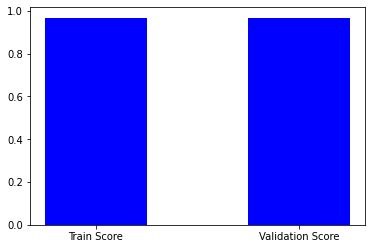

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.tphl)))
y = [neural_network_model.score(X_train, y_train.tphl), 
     neural_network_model.score(X_val, y_val.tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.tphl, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

###TPLH

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.tplh)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.tplh, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0003523014496010987


Text(0.5, 1.0, 'MLP, TPLH')

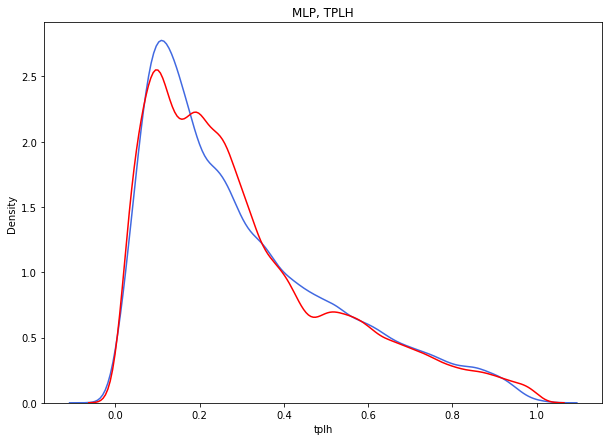

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.tplh, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, TPLH')

Score on training set: 0.993
Score on validation set: 0.993
Mean squared error (MSE): 0.0003523014496010987


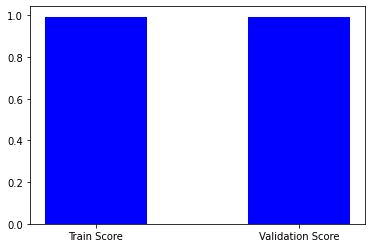

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.tplh)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.tplh)))
y = [neural_network_model.score(X_train, y_train.tplh), 
     neural_network_model.score(X_val, y_val.tplh)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.tplh, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

###IINT

In [ ]:
# treinando o modelo com os dados de treino
neural_network_model.fit(X_train, y_train.iint)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
mse = mean_squared_error(y_val.iint, y_pred)
print(f'clf: MLP, mse: {mse}')

clf: MLP, mse: 0.0005599333245738104


Text(0.5, 1.0, 'MLP, IINT')

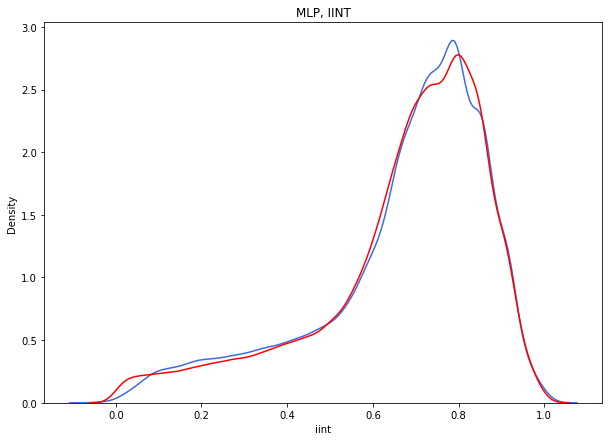

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,7))
sns.kdeplot(data=y_pred, label = 'predicted', ax = ax,color = 'royalblue')
sns.kdeplot(data=y_val.iint, label = 'true', ax = ax, color = 'red')
ax.set_title('MLP, IINT')

Score on training set: 0.987
Score on validation set: 0.987
Mean squared error (MSE): 0.0005599333245738104


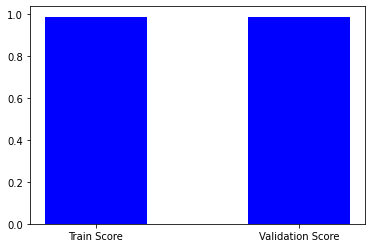

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train, y_train.iint)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val, y_val.iint)))
y = [neural_network_model.score(X_train, y_train.iint), 
     neural_network_model.score(X_val, y_val.iint)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
#print("Explained variance score: {}".format(explained_variance_score(y_val.tphl, y_pred)))
#print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val.tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val.iint, y_pred)))
#print("R² Score: {:.3f}".format(r2_score(y_val.tphl, y_pred)))

# Old Models



## Neural Net #0 (Try hard mode)

In [ ]:
import tensorflow as tf

In [ ]:
ann = tf.keras.models.Sequential()

Vou fazer apenas um output inicialmente (tphl, coluna 0) para ver como performa, abaixo é o código para a arquitetura e compilação com backpropagation. Vou fazer sem padronizar os dados de treinamento inicialmente

In [ ]:
#Hidden Layer 1
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
#Hidden Layer 2
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
#Hidden Layer 3
ann.add(tf.keras.layers.Dense(units=12, activation='relu'))
#Output Layer
ann.add(tf.keras.layers.Dense(units=1))

In [ ]:
ann.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
validation_tphl = y_val.tphl
train_tphl = y_train.tphl
test_tphl = yte

Bruh, o loss diminuiu bastante e até convergiu no epoch 6, mas as predições estão constantes... wtf? Tentarei normalizar, vamos ver se altera algo, se não é mexer na arquitetura pq o modelo não está aprendendo. Aparentemente o sem alterar os dados convergiu no 30 epoch tmb. Scheisse. A normalização ainda converge, porém os resultados constantes são mais próximos da escala esperada. Vou trabalhar com ela e ver se altero a arquitetura e outros parãmetros como o batch size. O batch size e as units não me parecem trazer alterações relevantes. Vou adicionar mais Layers na esperança de a ann aprender algo a mais, minha última alternativa é alterar a composição do dataset. O aumento para 4 layers com 12 units piorou os resultados

In [ ]:
ann.fit(X_train,train_tphl, batch_size=40, epochs=50)

In [ ]:
y_pred_nn0 = ann.predict(X_val)
#np.set_printoptions(precision=2)
print(np.concatenate((y_pred_nn0.reshape(len(y_pred_nn0),1), a.reshape(len(a),1)), axis=1))

## Neural Net #1 (Multilayer Perceptron Sklearn)

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
"""from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_val_scaled = sc.transform(X_val)"""

In [ ]:
# criando o objeto do modelo com MLPRegressor
neural_network_model = MLPRegressor(activation='tanh', 
                                    solver = 'lbfgs',
                                    hidden_layer_sizes=(100),
                                    early_stopping = True)

# treinando o modelo com os dados de treino
neural_network_model.fit(X_train_norm, train_tphl)

# prever com o modelo nos dados de validacao
y_pred = neural_network_model.predict(X_val_norm)

In [ ]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), validation_tphl.reshape(len(validation_tphl),1)), axis=1))

[[-1.35e-04  9.68e-12]
 [ 1.02e-04  1.35e-11]
 [-5.48e-03  7.57e-12]
 ...
 [-1.57e-04  8.69e-12]
 [-1.75e-04  1.37e-11]
 [-1.91e-04  5.91e-12]]


Score on training set: -598198417686226560.000
Score on validation set: -601938109190083200.000
Explained variance score: -6.019363056862876e+17
Mean absolute error (MAE): 0.002912541559344496
Mean squared error (MSE): 1.3897360339482752e-05
R² Score: -601938109190083200.000


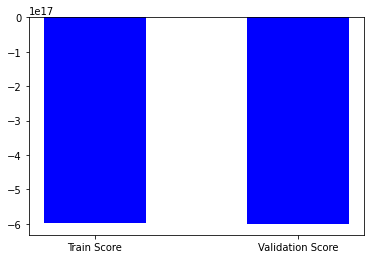

In [ ]:
print("Score on training set: {:.3f}".format(neural_network_model.score(X_train_norm, train_tphl)))
print("Score on validation set: {:.3f}".format(neural_network_model.score(X_val_norm, validation_tphl)))
y = [neural_network_model.score(X_train_norm, train_tphl), 
     neural_network_model.score(X_val_norm, validation_tphl)]
x = ["Train Score", "Validation Score"]
width = 1/2
plt.bar(x, y, width, color="blue") 
print("Explained variance score: {}".format(explained_variance_score(validation_tphl, y_pred)))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(validation_tphl, y_pred)))
print("Mean squared error (MSE): {}".format(mean_squared_error(validation_tphl, y_pred)))
print("R² Score: {:.3f}".format(r2_score(validation_tphl, y_pred)))

##Neural Net #2 (Keras with multioutput)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# get the model
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mae', optimizer='adam')
	return model
  
# evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
	results = list()
	n_inputs, n_outputs = 7, 3
	# define evaluation procedure
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	# enumerate folds
	for train_ix, test_ix in cv.split(X):
		# prepare data
		X_train, X_test = X[train_ix], X[test_ix]
		y_train, y_test = y[train_ix], y[test_ix]
		# define model
		model = get_model(n_inputs, n_outputs)
		# fit model
		model.fit(X_train, y_train, verbose=0, epochs=100)
		# evaluate model on test set
		mae = model.evaluate(X_test, y_test, verbose=0)
		# store result
		print('>%.3f' % mae)
		results.append(mae)
	return results

# evaluate model
results = evaluate_model(X, y)
# summarize performance
print('MAE: %.3f (%.3f)' % (mean(results), std(results)))

TypeError: ignored

In [ ]:
def get_model(n_inputs, n_outputs):
	model = Sequential()
	model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
	model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
	model.compile(loss='mae', optimizer='adam')
	return model
 
# load dataset
n_inputs, n_outputs = X.shape[1], y.shape[1]
# get model
model = get_model(n_inputs, n_outputs)
# fit the model on all data
model.fit(X_train, y_train, verbose=0, epochs=100)
# make a prediction for new data
yhat = model.predict(X_val)
print('Predicted: %s' % yhat[0])

## Random Forest MultiOutput

In [ ]:
##### RandomForest tphl
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rf_model =  MultiOutputRegressor(RandomForestRegressor(random_state=seed)).fit(X_train, y_train)

y_pred_1 = rf_model.predict(X_val)

In [ ]:
print(np.concatenate((y_pred_1.reshape(len(y_pred_1),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.25e-11  2.34e-11 -1.46e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, y_pred_1, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, y_pred_1, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [5.33e-15 1.89e-15 2.00e-15]
Mean absolute error (MAE): [3.85e-12 1.14e-11 3.63e-16]
Mean squared error (MSE): [2.31e-23 2.03e-22 2.25e-31]


In [ ]:
from sklearn.model_selection import GridSearchCV
"""
params = {'n_estimators': [5, 50, 100, 500],
          'max_features': [2, 5, 7],
          'max_depth': [2, 5, 10, 50],
          'min_samples_split': [2, 8, 15, 30],}

# criando o objeto do modelo com RandomForestRegressor
rf_model_cv_gs = RandomForestRegressor(random_state = seed)

# criando o objeto do grid search com GridSearchCV
grid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3

# treinando o modelo com o grid search
grid_search.fit(X_training, y_training)

# imprimindo a melhor combinação de hiperparâmetros
print('\n Best hyperparameters:')
print(grid_search.best_params_)

# pegando os resultados da validação cruzada (cv_results)
cv_results = pd.DataFrame(grid_search.cv_results_)

# imprimindo o score médio nas bases de treino
print("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_train_score.values[0]))
# imprimindo o score médio nas bases de validação
print("Average Score on validation set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_test_score.values[0],
                                                                     cv_results[cv_results.rank_test_score == 1].std_test_score.values[0])) """

'\nparams = {\'n_estimators\': [5, 50, 100, 500],\n          \'max_features\': [2, 5, 7],\n          \'max_depth\': [2, 5, 10, 50],\n          \'min_samples_split\': [2, 8, 15, 30],}\n\n# criando o objeto do modelo com RandomForestRegressor\nrf_model_cv_gs = RandomForestRegressor(random_state = seed)\n\n# criando o objeto do grid search com GridSearchCV\ngrid_search = GridSearchCV(rf_model_cv_gs, param_grid=params, return_train_score=True) # valor padrão para quebras é 3\n\n# treinando o modelo com o grid search\ngrid_search.fit(X_training, y_training)\n\n# imprimindo a melhor combinação de hiperparâmetros\nprint(\'\n Best hyperparameters:\')\nprint(grid_search.best_params_)\n\n# pegando os resultados da validação cruzada (cv_results)\ncv_results = pd.DataFrame(grid_search.cv_results_)\n\n# imprimindo o score médio nas bases de treino\nprint("Average Score on train set: {:.3f} +/- {:.3f}".format(cv_results[cv_results.rank_test_score == 1].mean_train_score.values[0],\n                  

In [ ]:
"""Best hyperparameters:
{'max_depth': 2, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 100}
Average Score on train set: -0.000 +/- 0.000
Average Score on validation set: -0.000 +/- 0.000"""

# configurando o modelo com a melhor combinação de hiperparâmetros
"""rf_model_cv_gs.set_params(n_estimators = grid_search.best_params_['n_estimators'],
                           max_features = grid_search.best_params_['max_features'],
                           max_depth = grid_search.best_params_['max_depth'],
                           min_samples_split = grid_search.best_params_['min_samples_split'])"""

rf_model_cv_gs = RandomForestRegressor(random_state = seed)

rf_model_cv_gs.set_params(n_estimators = 100,
                           max_features = 2,
                           max_depth = 2,
                           min_samples_split = 2)
# treinando um modelo com a melhor combinação de hiperparâmetros
rf_model_cv_gs.fit(normalize(X_training), y_training)

"""features = X_train.columns
importances = rf_model_cv_gs.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()"""

"features = X_train.columns\nimportances = rf_model_cv_gs.feature_importances_\nindices = np.argsort(importances)\n\nplt.title('Feature Importances')\nplt.barh(range(len(indices)), importances[indices], color='b', align='center')\nplt.yticks(range(len(indices)), [features[i] for i in indices])\nplt.xlabel('Relative Importance')\nplt.show()"

In [ ]:
pred = rf_model_cv_gs.predict(normalize(X_test))
print(np.concatenate((pred.reshape(len(pred),3), y_test.reshape(len(y_test),3)), axis=1))

[[ 1.25e-11  2.34e-11 -1.46e-15  6.59e-12  7.30e-12 -2.95e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.78e-12  5.21e-12 -1.90e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  9.29e-12  1.76e-11 -1.44e-15]
 ...
 [ 1.25e-11  2.34e-11 -1.46e-15  8.86e-12  1.34e-11 -1.41e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  1.53e-11  2.20e-11 -1.52e-15]
 [ 1.25e-11  2.34e-11 -1.46e-15  6.49e-12  5.95e-12 -1.60e-15]]


##SVR Polynomial MultiOutput


In [ ]:
from sklearn.svm import SVR
SVR = MultiOutputRegressor(SVR(kernel = 'linear')).fit(normalize(X_train), y_train) # kernel='rbf', C, gamma
svr_pred = SVR.predict(normalize(X_val))

In [ ]:
print(np.concatenate((svr_pred.reshape(len(svr_pred),3), y_val.reshape(len(y_val),3)), axis=1))

[[ 1.68e-11  3.61e-11 -1.85e-15  9.68e-12  1.84e-11 -1.20e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.35e-11  1.43e-11 -9.02e-16]
 [ 1.68e-11  3.61e-11 -1.85e-15  7.57e-12  8.73e-12 -1.49e-15]
 ...
 [ 1.68e-11  3.61e-11 -1.85e-15  8.69e-12  1.75e-11 -1.64e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  1.37e-11  2.35e-11 -1.36e-15]
 [ 1.68e-11  3.61e-11 -1.85e-15  5.91e-12  3.01e-11 -2.11e-15]]


In [ ]:
print("Score on training set: {}".format(rf_model_1.score(X_train, y_train)))
print("Score on validation set: {}".format(rf_model_1.score(X_val, y_val)))

print("Explained variance score: {}".format(explained_variance_score(y_val, svr_pred, multioutput='raw_values')))
print("Mean absolute error (MAE): {}".format(mean_absolute_error(y_val, svr_pred, multioutput='raw_values')))
print("Mean squared error (MSE): {}".format(mean_squared_error(y_val, svr_pred, multioutput='raw_values')))

Score on training set: -2.6624674613155246e-08
Score on validation set: -7.082762035685401e-06
Explained variance score: [ 5.44e-15  1.89e-15 -6.66e-16]
Mean absolute error (MAE): [5.68e-12 1.71e-11 5.51e-16]
Mean squared error (MSE): [4.19e-23 3.64e-22 3.75e-31]


# Results

In [ ]:
from sklearn.metrics import (explained_variance_score, 
                             mean_absolute_error, 
                             mean_squared_error, 
                             mean_squared_log_error,
                             r2_score)

In [ ]:
def generate_model_scores_df(score,y_pred,model_name,new_df=True,df=None):
  if new_df:
    result = pd.DataFrame(columns=['TPHL', 'TPLH', 'IINT'], index=[model_name])
  else:
    result = df
  result.loc[model_name] = score(y_val, y_pred, multioutput='raw_values')
  return result

In [ ]:
sim_0 = pd.read_csv('/content/drive/MyDrive/UFSC (12019-12023)/PIC/Cmos Data/results_sim0.csv')

In [ ]:
#regre = mean_absolute_error(y_val, y_p, multioutput='raw_values')
randf1 = mean_absolute_error(y_val, y_pred_1, multioutput='raw_values')
#randf2 = mean_absolute_error(y_val, y_pred_2, multioutput='raw_values')
NN = mean_absolute_error(y_val,y_pred, multioutput='raw_values')
#NN2 = mean_absolute_error(y_val,yhat, multioutput='raw_values')

In [ ]:
metricas = pd.DataFrame([randf1,NN],index=['Floresta','MLP'],columns=['tphl','tplh','iint'])

In [ ]:
metricas

tphl          tplh          iint
Floresta  3.846058e-12  1.137435e-11  3.628414e-16
MLP       3.030069e-04  8.922528e-05  9.800367e-05